MERGE `MENSAL`
1. FTP dos dados: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/


# **1° Passo:** Preparando ambiente

In [68]:
# instala bibliotecas
!pip install -q ultraplot rasterio pyproj geopandas rioxarray geobr salem folium

# importa bibliotecas
import geobr
import ultraplot as uplt
import xarray as xr
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray
import geopandas as gpd
import salem
import folium
import warnings
warnings.filterwarnings("ignore")

# **2° Passo:** Download e Leitura do dado



In [7]:
# baixando os dados
!wget 'http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/MONTHLY_ACCUMULATED_YEARLY_ALL_TIME.nc' # 863 MB

--2025-04-19 15:28:54--  http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/MONTHLY_ACCUMULATED_YEARLY_ALL_TIME.nc
Resolving ftp.cptec.inpe.br (ftp.cptec.inpe.br)... 150.163.178.56
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/MONTHLY_ACCUMULATED_YEARLY_ALL_TIME.nc [following]
--2025-04-19 15:28:55--  https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/CLIMATOLOGY/MONTHLY_ACCUMULATED_YEARLY/MONTHLY_ACCUMULATED_YEARLY_ALL_TIME.nc
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 904695511 (863M) [application/x-netcdf]
Saving to: ‘MONTHLY_ACCUMULATED_YEARLY_ALL_TIME.nc’

MONTHLY_ACCUMULATED 100%[===================>] 862.78M  16.1MB/s    in 62s     

2025-04-19 15:29:

In [8]:
# leitura do dado
merge = xr.open_dataset('/content/MONTHLY_ACCUMULATED_YEARLY_ALL_TIME.nc')
merge

<xarray.Dataset> Size: 905MB
Dimensions:  (lon: 551, lat: 691, time: 297)
Coordinates:
  * lon      (lon) float64 4kB -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 6kB -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * time     (time) datetime64[ns] 2kB 2000-06-01T12:00:00 ... 2025-02-01T12:...
Data variables:
    pacum    (time, lat, lon) float64 905MB ...
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Sun Mar 16 21:40:11 2025: cdo mergetime MERGE_CPTEC_acum_ju...
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...

# **3° Passo:** Funções

In [9]:
# shapefile: Estado
def carrega_shape_estado(estado):
    estados_geobr = geobr.read_state(year=2020)
    estado_geobr = estados_geobr[estados_geobr['abbrev_state'] == estado]
    if estado_geobr.empty:
        raise ValueError(f"Não encontrado o estado '{estado}'.")
    estado_geobr.crs = 'epsg:4674'
    return estado_geobr

# shapefile: Município
def carrega_shape_municipio(municipio):
    municipios_geobr = geobr.read_municipality(code_muni="all", year=2020)
    municipio_geobr = municipios_geobr [municipios_geobr['name_muni'] == municipio]
    if municipios_geobr.empty:
        raise ValueError(f"Não encontrado o estado '{estado}'.")
    municipio_geobr.crs = 'epsg:4674'
    return municipio_geobr

# shapefile: Bacia
def carrega_shape_bacia(bacia):

    # Maiores informações: https://www.ibge.gov.br/geociencias/downloads-geociencias.html?caminho=informacoes_ambientais/estudos_ambientais/bacias_e_divisoes_hidrograficas_do_brasil/2021/Bacias_Hidrograficas_do_Brasil_BHB250/vetores/
    import zipfile
    import requests
    from io import BytesIO
    url = 'https://geoftp.ibge.gov.br/informacoes_ambientais/estudos_ambientais/bacias_e_divisoes_hidrograficas_do_brasil/2021/Bacias_Hidrograficas_do_Brasil_BHB250/vetores/bacias_nivel_4.zip'

    # baixar o conteúdo
    response = requests.get(url)
    zip_file = zipfile.ZipFile(BytesIO(response.content))

    # extrair os arquivos
    zip_file.extractall('bacias_nivel_4')

    # seleciona a bacia definida
    bacias = salem.read_shapefile(f'/content/bacias_nivel_4/bacias_nivel_4.shp')
    bacia = bacias[bacias['nome_bacia'] == bacia]

    return bacia

# **PARTE 1:** ESTADOS

## **Processamento**

In [10]:
%%time
#==========================================================================#
#                           PARÂMETROS GERAIS                              #
#==========================================================================#
ESTADO = 'MG'
NAME = f'Estado de {ESTADO}'

#==========================================================================#
#                           PROCESSAMENTO
#==========================================================================#
# carrega shapefile
shapefile_regiao = carrega_shape_estado(ESTADO)

# aplica máscara no dataset
merge_regiao = merge.salem.roi(shape=shapefile_regiao)

# calcula a média espacial dentro da região
ts_mensal = merge_regiao.mean(dim=["lat", "lon"])

# converte para DataFrame
ts_mensal = ts_mensal.to_dataframe().reset_index()

# transforma a coluna "time" para o índice da tabela
ts_mensal['time'] = pd.to_datetime(ts_mensal['time'])
ts_mensal.set_index('time', inplace=True)

# ordena o dataframe
ts_mensal = ts_mensal.sort_index()
display(ts_mensal)
#==========================================================================#

,pacum
time,
2000-06-01 12:00:00,2.008217
2000-07-01 12:00:00,11.887450
2000-08-01 12:00:00,21.184910
2000-09-01 12:00:00,67.296912
2000-10-01 12:00:00,43.406511
...,...
2024-10-01 12:00:00,119.245120
2024-11-01 12:00:00,169.449888
2024-12-01 12:00:00,204.852515


CPU times: user 2.65 s, sys: 1.41 s, total: 4.07 s
Wall time: 44.5 s


<Axes: >

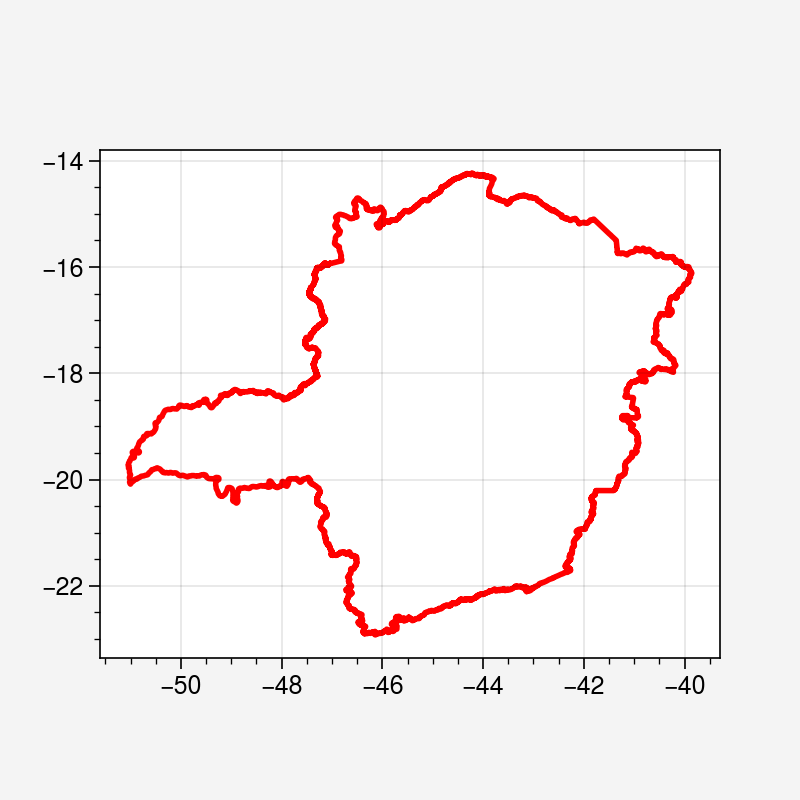

In [11]:
# plota figura da região de interesse
shapefile_regiao.plot(edgecolor='red',
                      facecolor='none',
                      linewidth=2,
                      alpha=1)

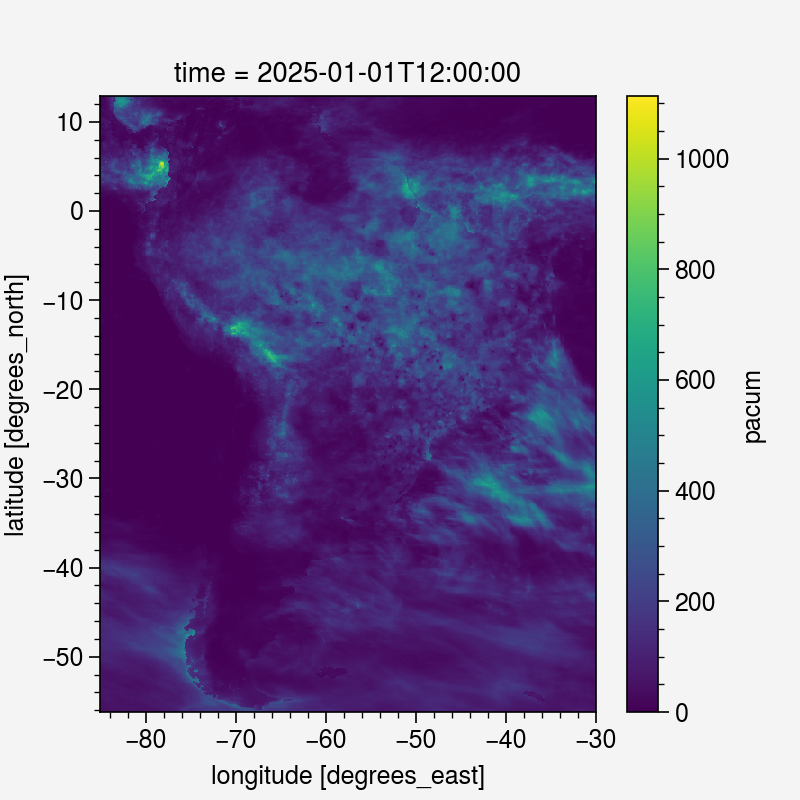

In [12]:
# figura total
merge['pacum'][-2,:,:].plot()

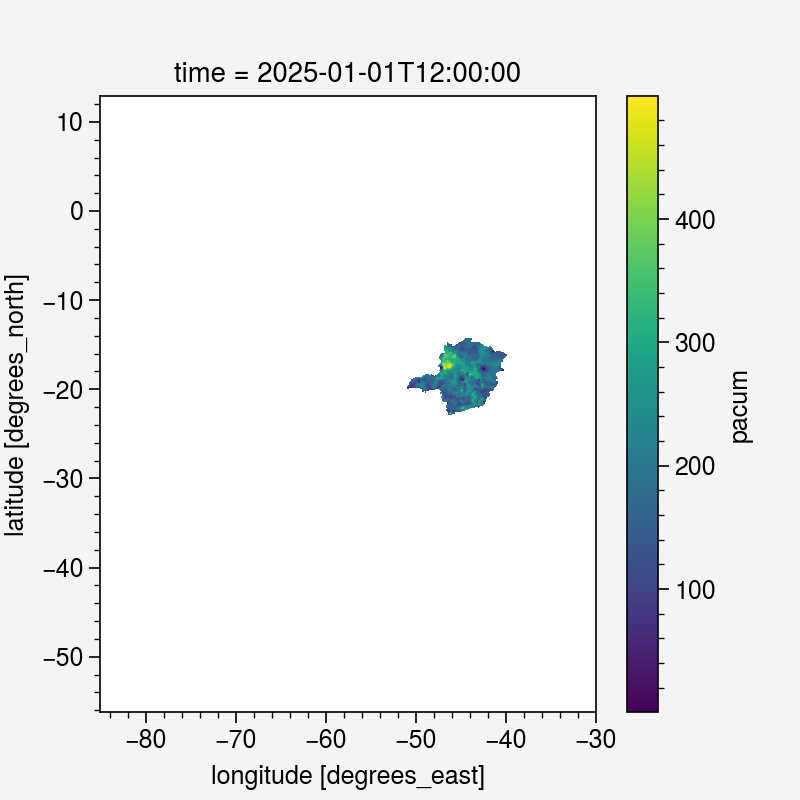

In [13]:
# figura com dados recortados
merge_regiao['pacum'][-2,:,:].plot()

## **Figura 1a:**  `TOTAL MENSAL`

In [14]:
# dado que será utilizado
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,2.008217
2000-07-01 12:00:00,11.887450
2000-08-01 12:00:00,21.184910
2000-09-01 12:00:00,67.296912


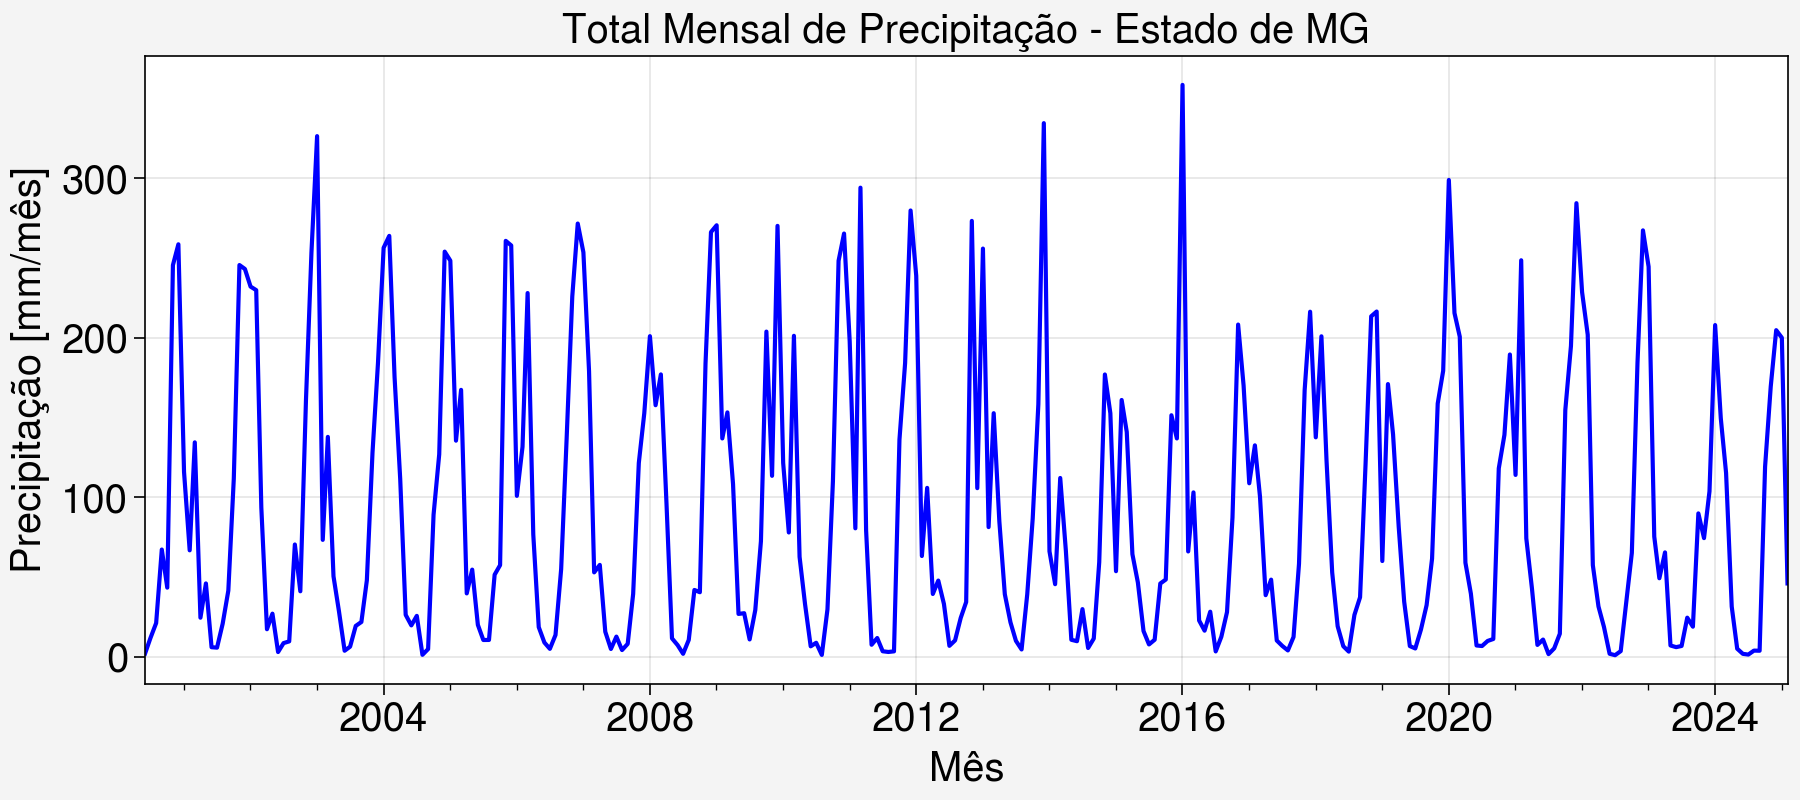

In [15]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(9,4), tight=True)

# plota gráfico de barras
ax.plot(ts_mensal['pacum'].index,
        ts_mensal['pacum'].values,
        color='blue')

# formato dos eixos
ax.format(title=f"Total Mensal de Precipitação - {NAME}",
          xlabel='Mês',
          ylabel='Precipitação [mm/mês]',
          small='20px',
          large='20px',
          xrotation=0,
          ytickminor=False)

# salva figura
fig.save(f"Fig_1a_precipitacao_total_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 1b:** `DISTRIBUIÇÃO MENSAL-BOXPLOT`

In [16]:
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,2.008217
2000-07-01 12:00:00,11.887450
2000-08-01 12:00:00,21.184910
2000-09-01 12:00:00,67.296912


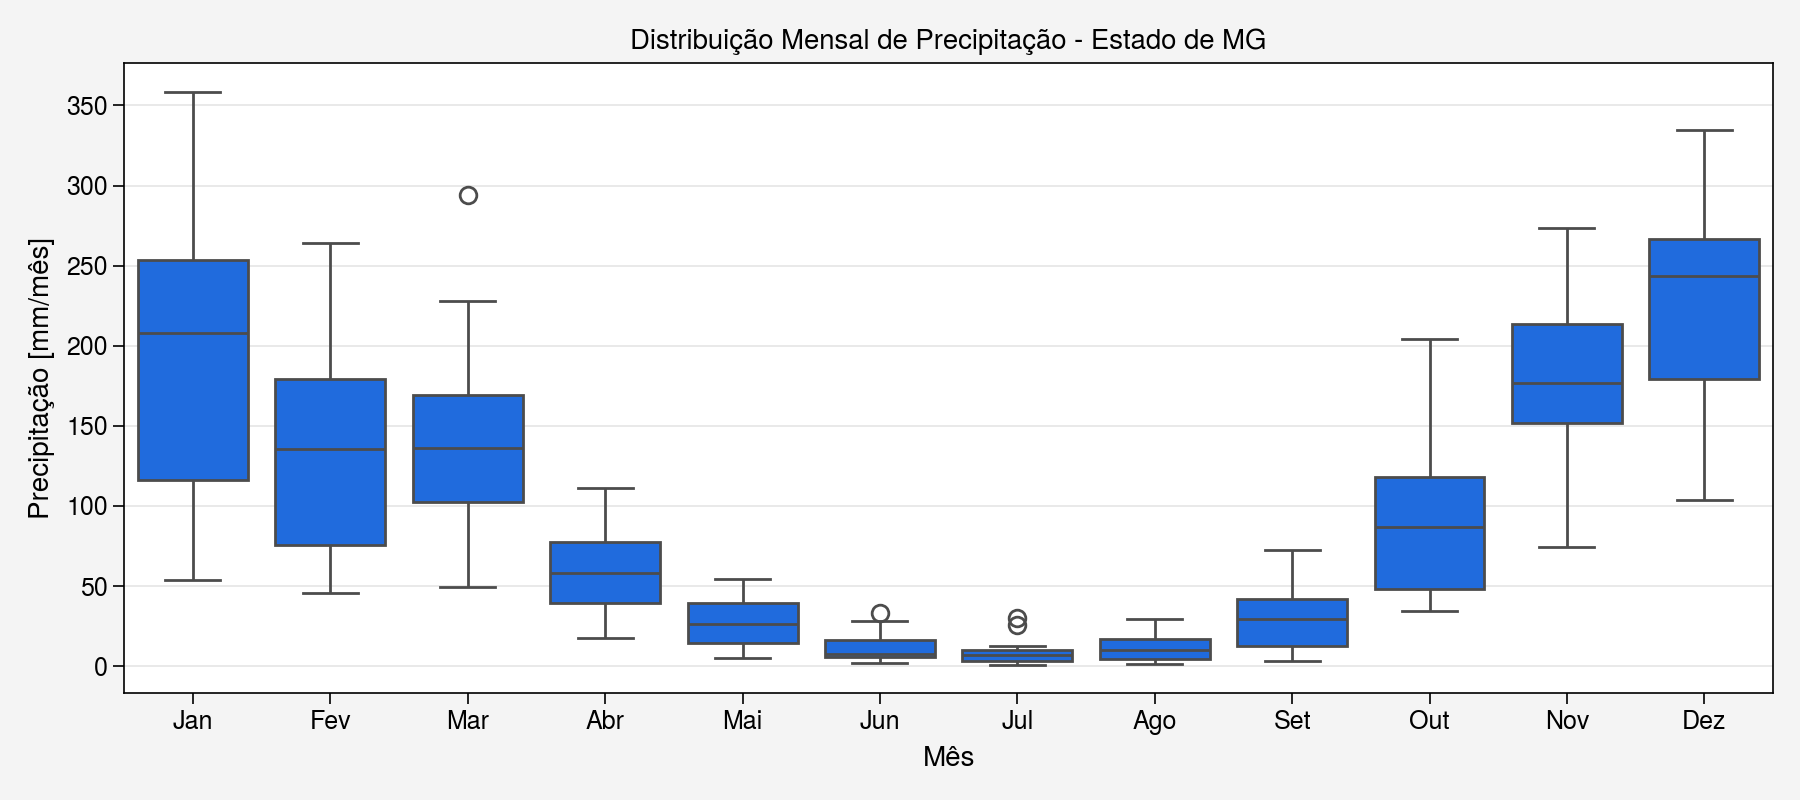

In [17]:
# cria moldura da figura
fig, ax = plt.subplots(figsize=(9, 4))

# criar boxplot de precipitação mensal
sns.boxplot(x=ts_mensal.index.month,
            y=ts_mensal['pacum'],
            ax=ax,
            color='bright blue')

# formatação dos eixos
ax.set_title(f"Distribuição Mensal de Precipitação - {NAME}")
ax.set_xlabel('Mês', fontsize=10)
ax.set_ylabel('Precipitação [mm/mês]', fontsize=10)
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)

# salva figura
plt.savefig(f"Fig_1b_precipitacao_distribuicao_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
plt.tight_layout()
plt.show()

## **Figura 1c:** `MENSAL CLIMATOLÓGICA`

In [18]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,2.008217
2000-07-01 12:00:00,11.887450
2000-08-01 12:00:00,21.184910
2000-09-01 12:00:00,67.296912
2000-10-01 12:00:00,43.406511
...,...
2024-10-01 12:00:00,119.245120
2024-11-01 12:00:00,169.449888
2024-12-01 12:00:00,204.852515


In [19]:
# climatológica
mensal_climatologia = ts_mensal.groupby(ts_mensal.index.month).mean()
mensal_climatologia

,pacum
time,
1,196.003897
2,135.725373
3,137.136796
4,58.587720
5,26.560833
6,11.303065
7,8.128714
8,11.356522
9,31.335950


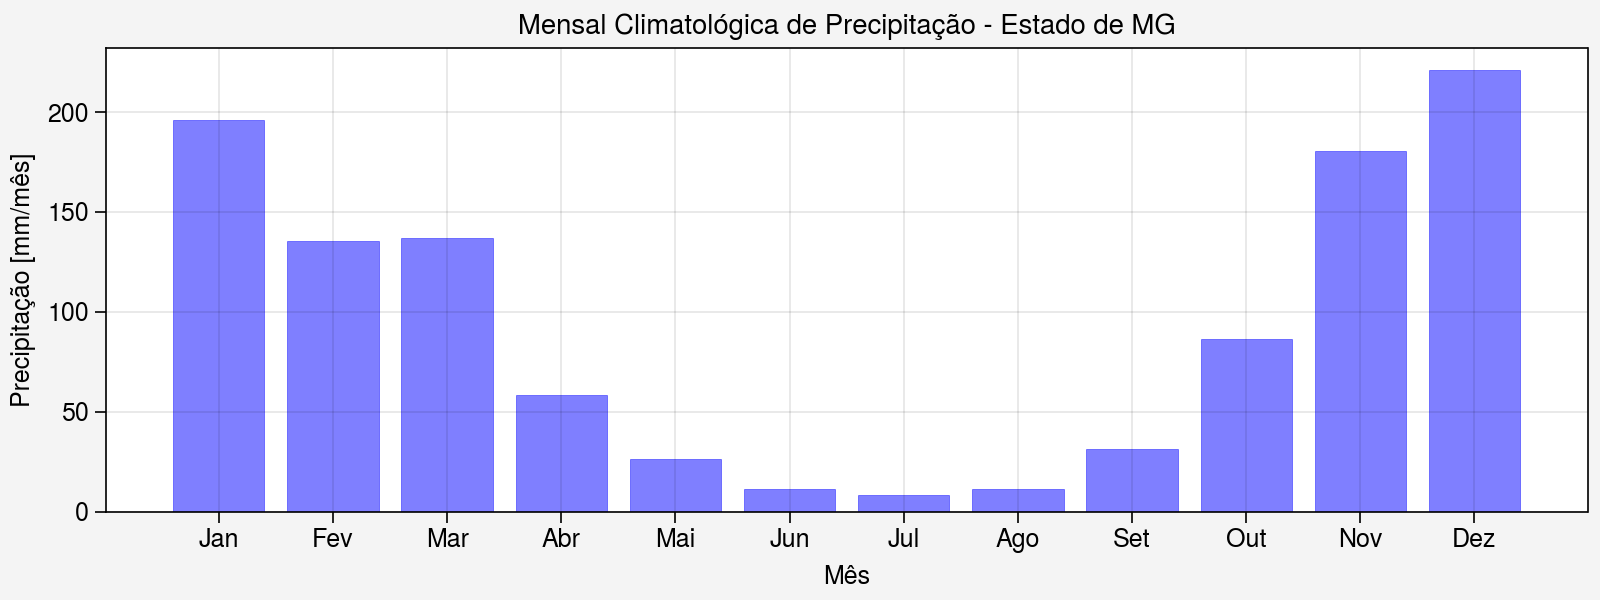

In [20]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(8, 3), tight=True)

# precipitação
ax.bar(uplt.arange(1, 12, 1),
       mensal_climatologia['pacum'],
       color='blue',
       alpha=0.5)

# formatações
ax.format(title=f"Mensal Climatológica de Precipitação - {NAME}",
          xlabel='Mês', ylabel='Precipitação [mm/mês]',
          xticklabels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
          xticks=uplt.arange(1, 12, 1),
          xtickminor=False, ytickminor=False)

# salva figura
fig.save(f"Fig_1c_precipitacao_mensal_climatologica_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 1d:** `POR ANO`

In [21]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,2.008217
2000-07-01 12:00:00,11.887450
2000-08-01 12:00:00,21.184910
2000-09-01 12:00:00,67.296912
2000-10-01 12:00:00,43.406511
...,...
2024-10-01 12:00:00,119.245120
2024-11-01 12:00:00,169.449888
2024-12-01 12:00:00,204.852515


In [22]:
# total
anual = ts_mensal.groupby(pd.Grouper(freq='1Y')).sum()
anual

,pacum
time,
2000-12-31,650.104208
2001-12-31,1062.723506
2002-12-31,1147.739069
2003-12-31,1028.686292
2004-12-31,1355.715202
2005-12-31,1315.029806
2006-12-31,1273.477117
2007-12-31,902.957968
2008-12-31,1196.131013


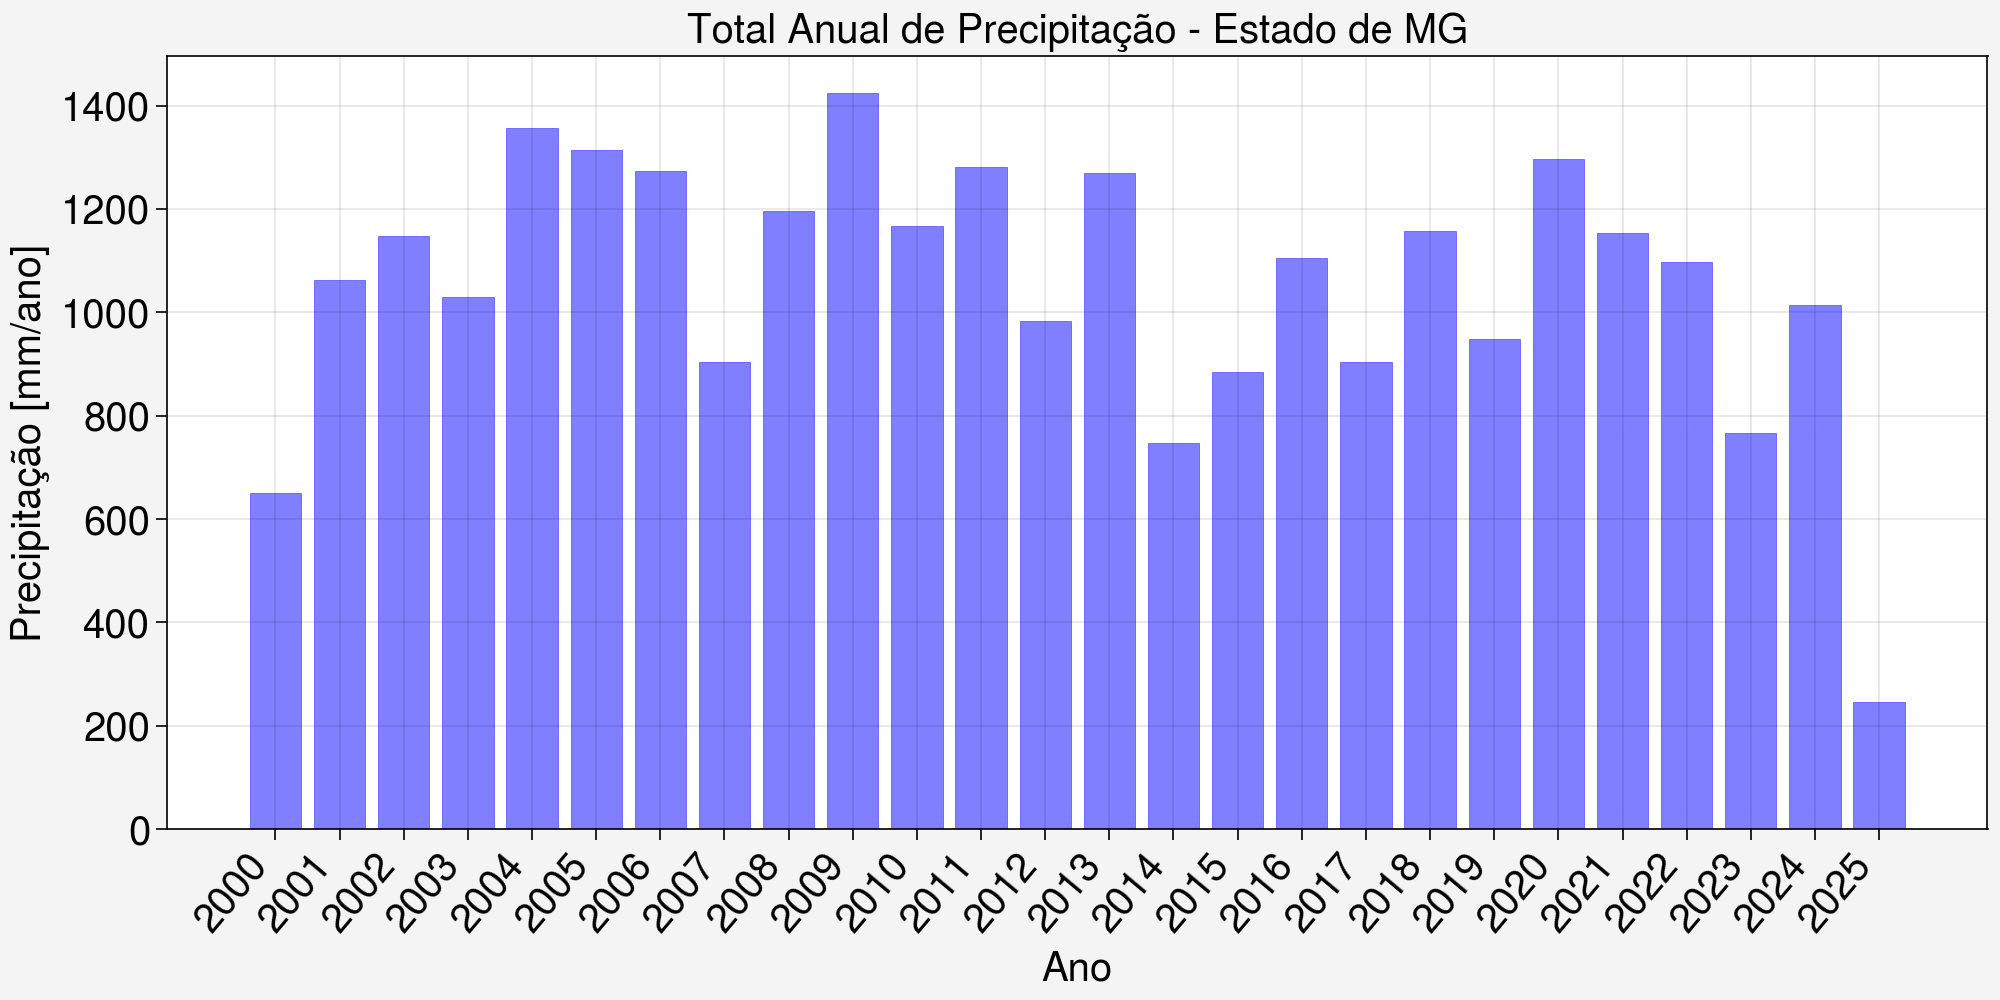

In [23]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(anual.index.year,
       anual['pacum'].values,
       color='blue',
       alpha=0.5)

# formatação do eixo
ax.format(title=f'Total Anual de Precipitação - {NAME}',
          xlabel='Ano',
          ylabel='Precipitação [mm/ano]',
          small='20px',
          large='20px',
          xtickminor=False,
          ytickminor=False,
          xticks=uplt.arange( anual.index.year[0], anual.index.year[-1], 1),
          xrotation=50)

# salva figura
fig.save(f"Fig_1d_precipitacao_total_anual_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

# **PARTE 2:** MUNICÍPIOS

## **Processamento**

In [24]:
%%time
#==========================================================================#
#                           PARÂMETROS GERAIS                              #
#==========================================================================#
ESTADO = 'SP'
MUNICIPIO = 'Marília'
NAME = f'{MUNICIPIO}/{ESTADO}'

#==========================================================================#
#                           PROCESSAMENTO
#==========================================================================#
# carrega shapefile
shapefile_regiao = carrega_shape_municipio(MUNICIPIO)

# aplicar máscara no dataset
merge_regiao = merge.salem.roi(shape=shapefile_regiao)

# calcula a média espacial dentro da região
ts_mensal = merge_regiao.mean(dim=["lat", "lon"])

# converte para DataFrame
ts_mensal = ts_mensal.to_dataframe().reset_index()

# transforma a coluna "time" para o índice da tabela
ts_mensal['time'] = pd.to_datetime(ts_mensal['time'])
ts_mensal.set_index('time', inplace=True)

# ordena o dataframe
ts_mensal = ts_mensal.sort_index()
display(ts_mensal)
#==========================================================================#

,pacum
time,
2000-06-01 12:00:00,17.680556
2000-07-01 12:00:00,62.069444
2000-08-01 12:00:00,76.000000
2000-09-01 12:00:00,135.222222
2000-10-01 12:00:00,40.222222
...,...
2024-10-01 12:00:00,54.472222
2024-11-01 12:00:00,199.534722
2024-12-01 12:00:00,273.611111


CPU times: user 2.39 s, sys: 1.3 s, total: 3.68 s
Wall time: 41.8 s


<Axes: >

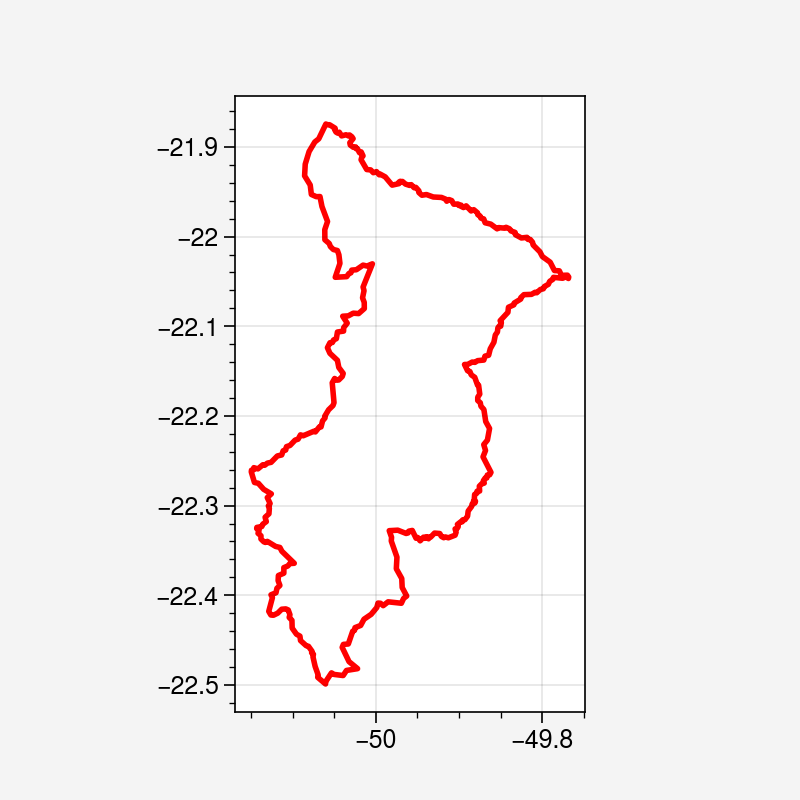

In [25]:
# plota figura da região de interesse
shapefile_regiao.plot(edgecolor='red',
                      facecolor='none',
                      linewidth=2,
                      alpha=1)

## **Figura 2a:**  `TOTAL MENSAL`

In [26]:
# dado que será utilizado
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,17.680556
2000-07-01 12:00:00,62.069444
2000-08-01 12:00:00,76.000000
2000-09-01 12:00:00,135.222222


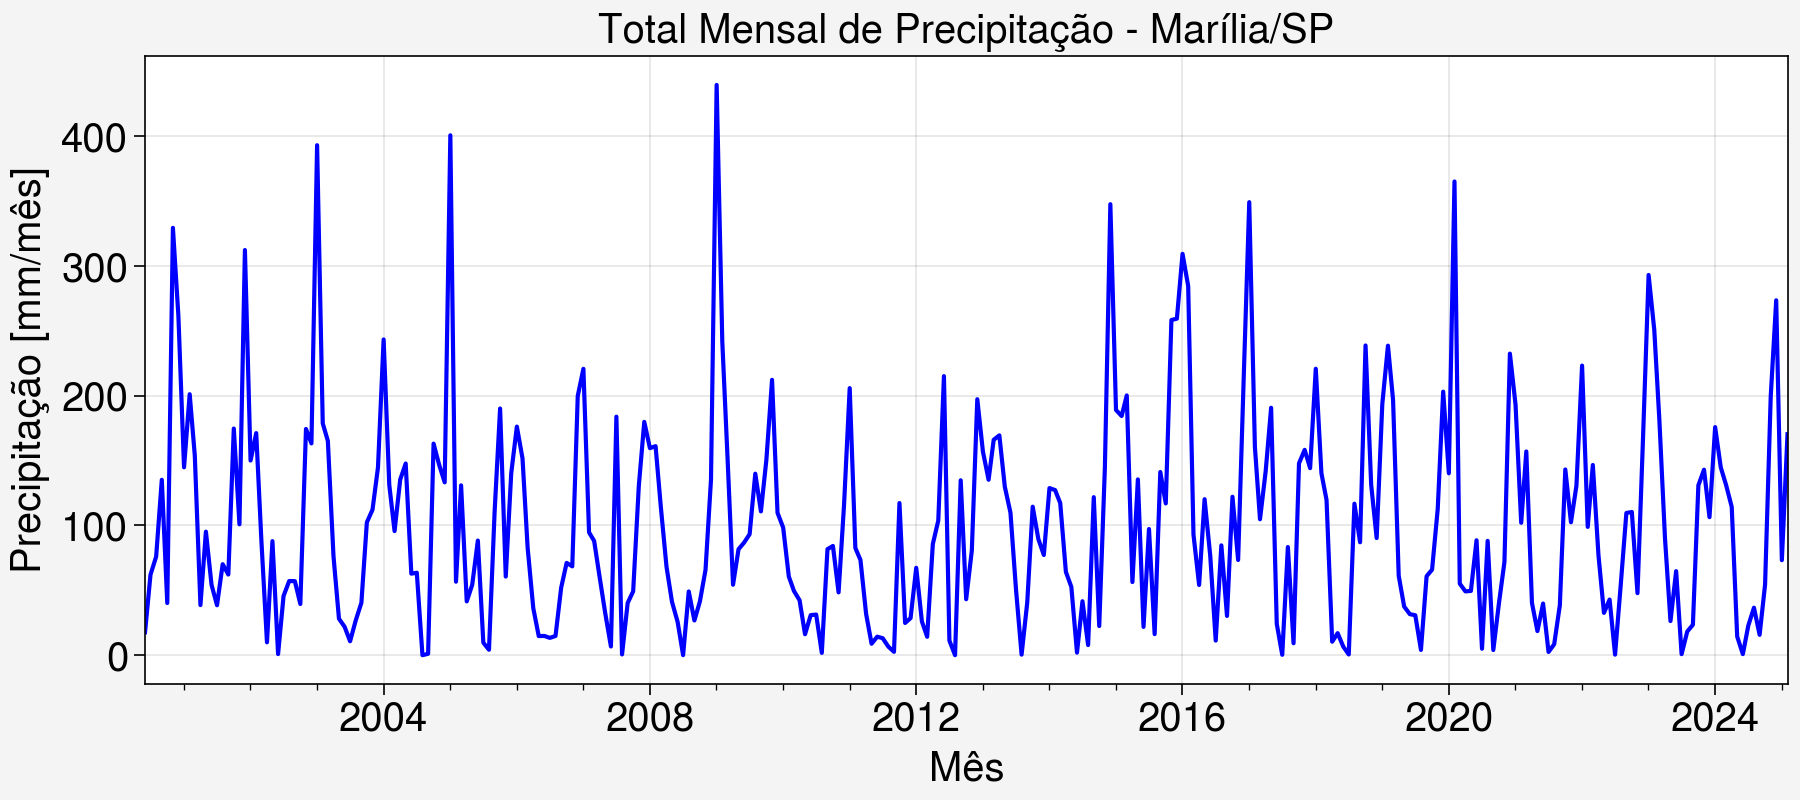

In [27]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(9,4), tight=True)

# plota gráfico de barras
ax.plot(ts_mensal['pacum'].index,
        ts_mensal['pacum'].values,
        color='blue')

# formato dos eixos
ax.format(title=f"Total Mensal de Precipitação - {NAME}",
          xlabel='Mês',
          ylabel='Precipitação [mm/mês]',
          small='20px',
          large='20px',
          xrotation=0,
          ytickminor=False)

# salva figura
fig.save(f"Fig_2a_precipitacao_total_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 2b:** `DISTRIBUIÇÃO MENSAL-BOXPLOT`

In [28]:
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,17.680556
2000-07-01 12:00:00,62.069444
2000-08-01 12:00:00,76.000000
2000-09-01 12:00:00,135.222222


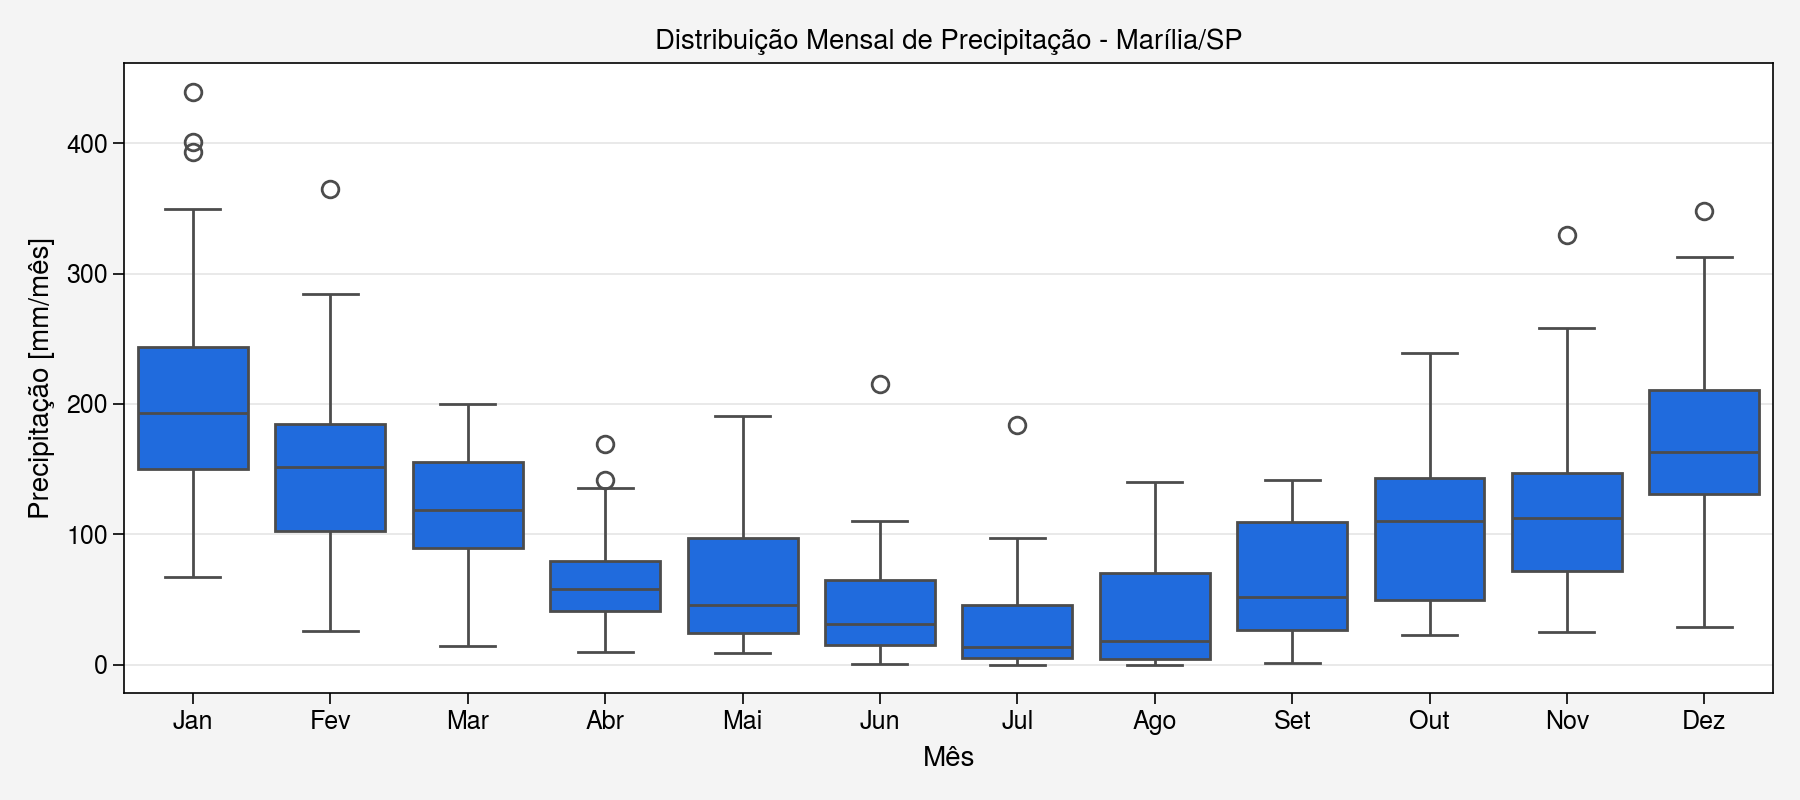

In [29]:
# cria moldura da figura
fig, ax = plt.subplots(figsize=(9, 4))

# criar boxplot de precipitação mensal
sns.boxplot(x=ts_mensal.index.month,
            y=ts_mensal['pacum'],
            ax=ax,
            color='bright blue')

# formatação dos eixos
ax.set_title(f"Distribuição Mensal de Precipitação - {NAME}")
ax.set_xlabel('Mês', fontsize=10)
ax.set_ylabel('Precipitação [mm/mês]', fontsize=10)
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)

# salva figura
plt.savefig(f"Fig_2b_precipitacao_distribuicao_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
plt.tight_layout()
plt.show()

## **Figura 2c:** `MENSAL CLIMATOLÓGICA`

In [30]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,17.680556
2000-07-01 12:00:00,62.069444
2000-08-01 12:00:00,76.000000
2000-09-01 12:00:00,135.222222
2000-10-01 12:00:00,40.222222
...,...
2024-10-01 12:00:00,54.472222
2024-11-01 12:00:00,199.534722
2024-12-01 12:00:00,273.611111


In [31]:
# climatológica
mensal_climatologia = ts_mensal.groupby(ts_mensal.index.month).mean()
mensal_climatologia

,pacum
time,
1,213.889306
2,158.450833
3,120.076100
4,67.000000
5,64.045428
6,46.005833
7,33.651111
8,38.658056
9,61.537778


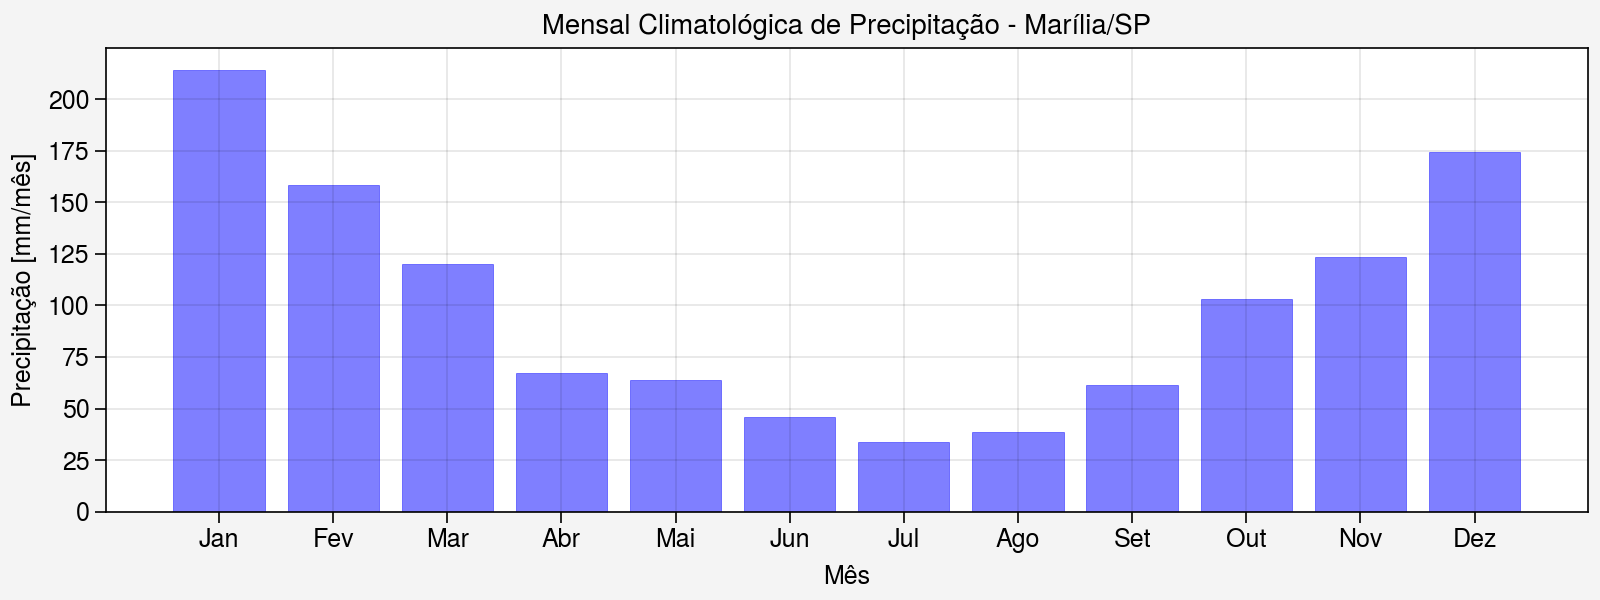

In [32]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(8, 3), tight=True)

# precipitação
ax.bar(uplt.arange(1, 12, 1),
       mensal_climatologia['pacum'],
       color='blue',
       alpha=0.5)

# formatações
ax.format(title=f"Mensal Climatológica de Precipitação - {NAME}",
          xlabel='Mês', ylabel='Precipitação [mm/mês]',
          xticklabels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
          xticks=uplt.arange(1, 12, 1),
          xtickminor=False, ytickminor=False)

# salva figura
fig.save(f"Fig_2c_precipitacao_mensal_climatologica_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 2d:** `POR ANO`

In [33]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,17.680556
2000-07-01 12:00:00,62.069444
2000-08-01 12:00:00,76.000000
2000-09-01 12:00:00,135.222222
2000-10-01 12:00:00,40.222222
...,...
2024-10-01 12:00:00,54.472222
2024-11-01 12:00:00,199.534722
2024-12-01 12:00:00,273.611111


In [34]:
# total
anual = ts_mensal.groupby(pd.Grouper(freq='1Y')).sum()
anual

,pacum
time,
2000-12-31,922.250000
2001-12-31,1447.097222
2002-12-31,1046.618056
2003-12-31,1300.763889
2004-12-31,1324.131944
2005-12-31,1288.298611
2006-12-31,896.472222
2007-12-31,1086.284722
2008-12-31,888.090278


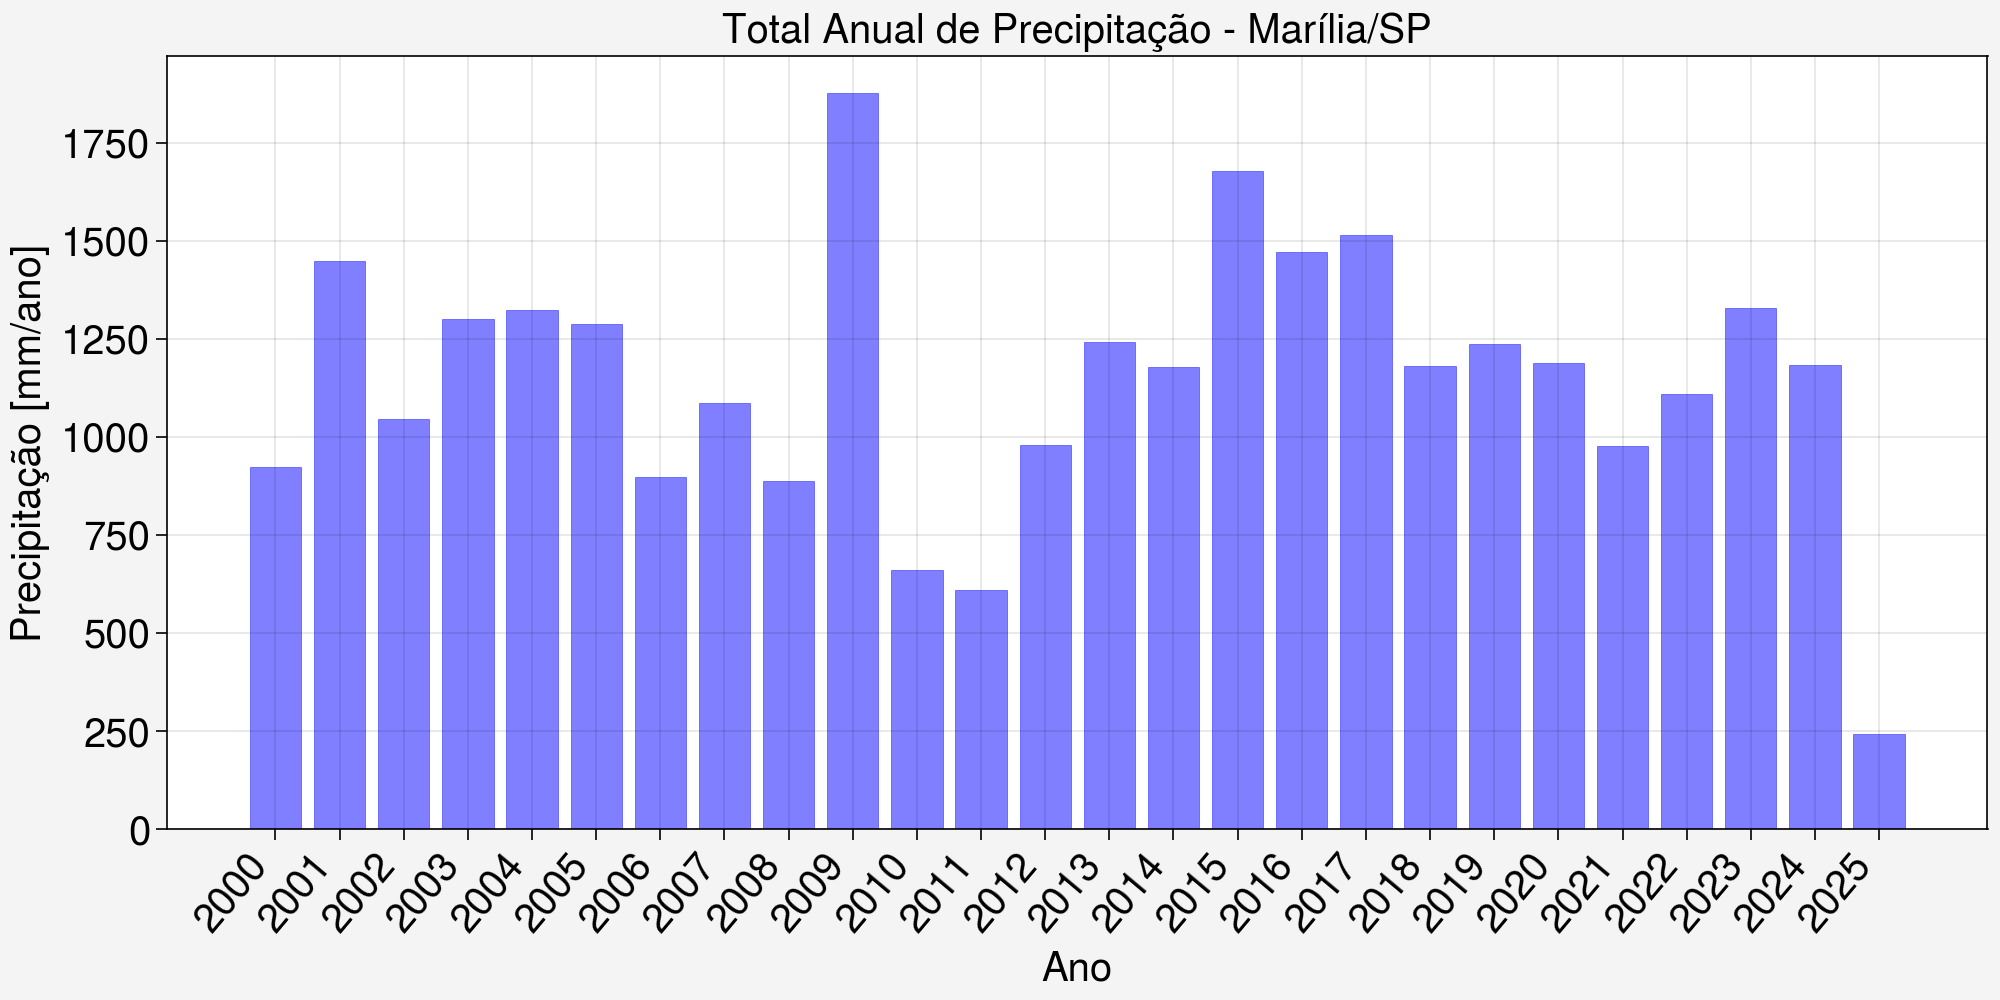

In [35]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(anual.index.year,
       anual['pacum'].values,
       color='blue',
       alpha=0.5)

# formatação do eixo
ax.format(title=f'Total Anual de Precipitação - {NAME}',
          xlabel='Ano',
          ylabel='Precipitação [mm/ano]',
          small='20px',
          large='20px',
          xtickminor=False,
          ytickminor=False,
          xticks=uplt.arange( anual.index.year[0], anual.index.year[-1], 1),
          xrotation=50)

# salva figura
fig.save(f"Fig_2d_precipitacao_total_anual_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

# **PARTE 3:** BACIAS

## **Processamento**

In [31]:
%%time
#==========================================================================#
#                           PARÂMETROS GERAIS                              #
#==========================================================================#
BACIA = 'Bacia do Rio Paraíba do Sul'
NAME = f'{BACIA}'

#==========================================================================#
#                           PROCESSAMENTO
#==========================================================================#
# carrega shapefile
shapefile_regiao = carrega_shape_bacia(BACIA)

# aplicar máscara no dataset
merge_regiao = merge.salem.roi(shape=shapefile_regiao)

# calcula a média espacial dentro da região
ts_mensal = merge_regiao.mean(dim=["lat", "lon"])

# converte para DataFrame
ts_mensal = ts_mensal.to_dataframe().reset_index()

# transforma a coluna "time" para o índice da tabela
ts_mensal['time'] = pd.to_datetime(ts_mensal['time'])
ts_mensal.set_index('time', inplace=True)

# ordena o dataframe
ts_mensal = ts_mensal.sort_index()
display(ts_mensal)
#==========================================================================#

,pacum
time,
2000-06-01 12:00:00,2.487140
2000-07-01 12:00:00,31.804784
2000-08-01 12:00:00,47.112397
2000-09-01 12:00:00,97.373200
2000-10-01 12:00:00,72.781250
...,...
2024-10-01 12:00:00,124.668724
2024-11-01 12:00:00,167.947788
2024-12-01 12:00:00,233.925412


CPU times: user 2.38 s, sys: 1.13 s, total: 3.51 s
Wall time: 6.24 s


<Axes: >

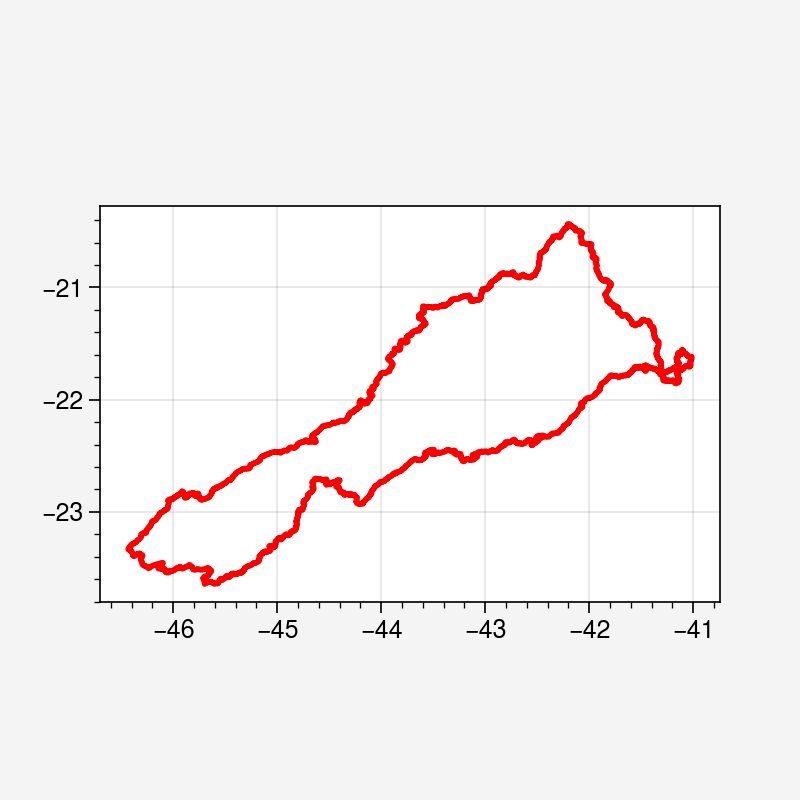

In [32]:
# plota figura da região de interesse
shapefile_regiao.plot(edgecolor='red',
                      facecolor='none',
                      linewidth=2,
                      alpha=1)

## **Figura 3a:**  `TOTAL MENSAL`

In [33]:
# dado que será utilizado
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,2.487140
2000-07-01 12:00:00,31.804784
2000-08-01 12:00:00,47.112397
2000-09-01 12:00:00,97.373200


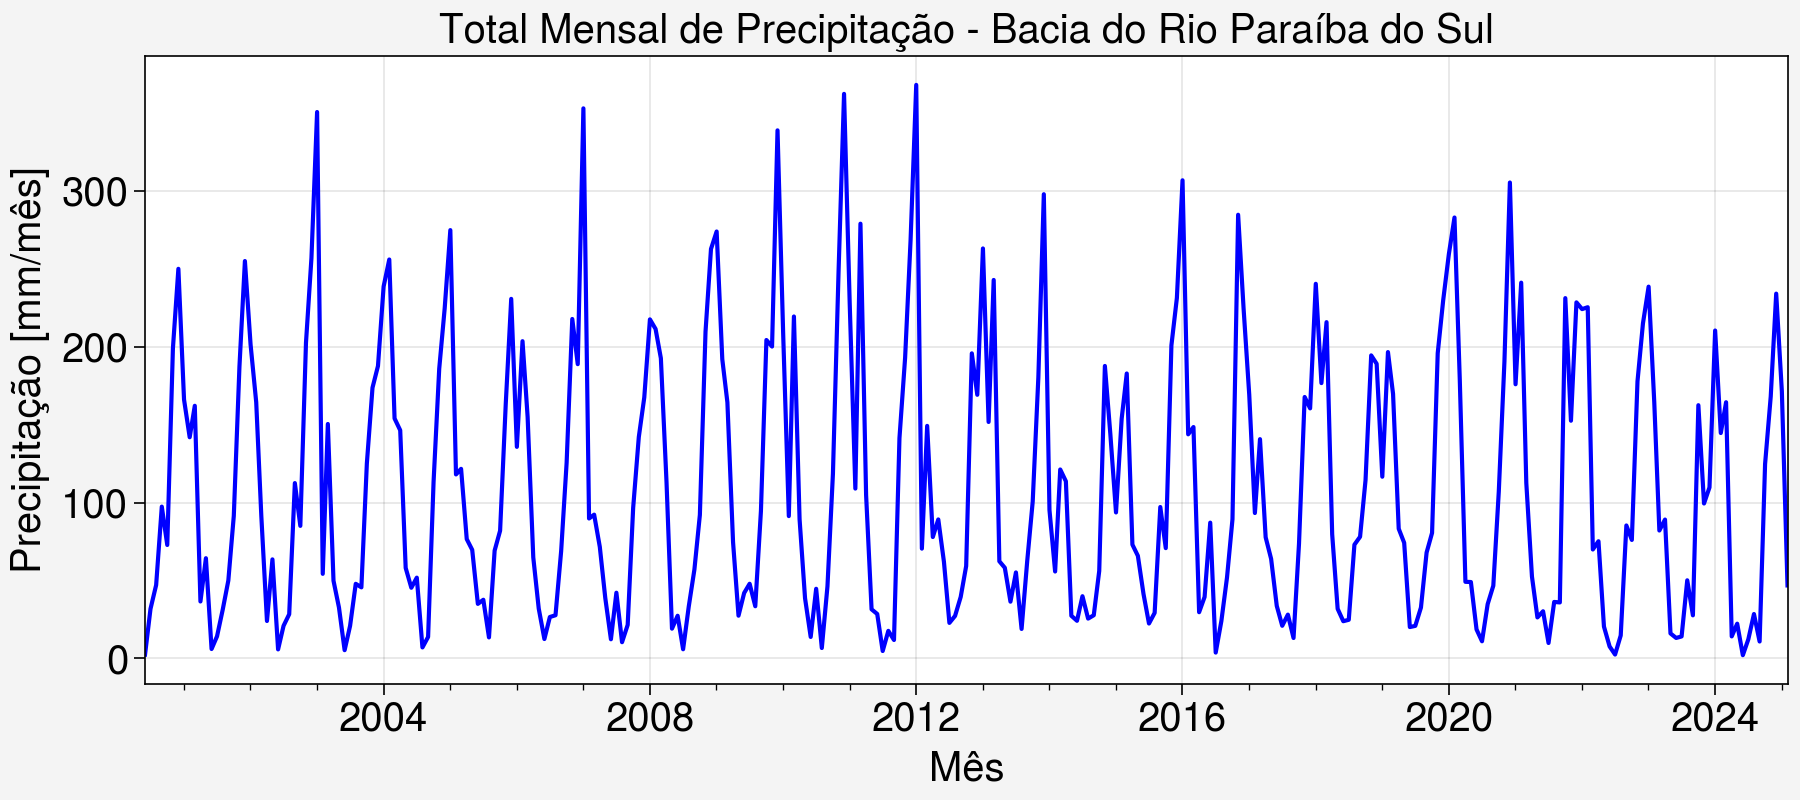

In [34]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(9,4), tight=True)

# plota gráfico de barras
ax.plot(ts_mensal['pacum'].index,
        ts_mensal['pacum'].values,
        color='blue')

# formato dos eixos
ax.format(title=f"Total Mensal de Precipitação - {NAME}",
          xlabel='Mês',
          ylabel='Precipitação [mm/mês]',
          small='20px',
          large='20px',
          xrotation=0,
          ytickminor=False)

# salva figura
fig.save(f"Fig_3a_precipitacao_total_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 3b:** `DISTRIBUIÇÃO MENSAL-BOXPLOT`

In [35]:
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,2.487140
2000-07-01 12:00:00,31.804784
2000-08-01 12:00:00,47.112397
2000-09-01 12:00:00,97.373200


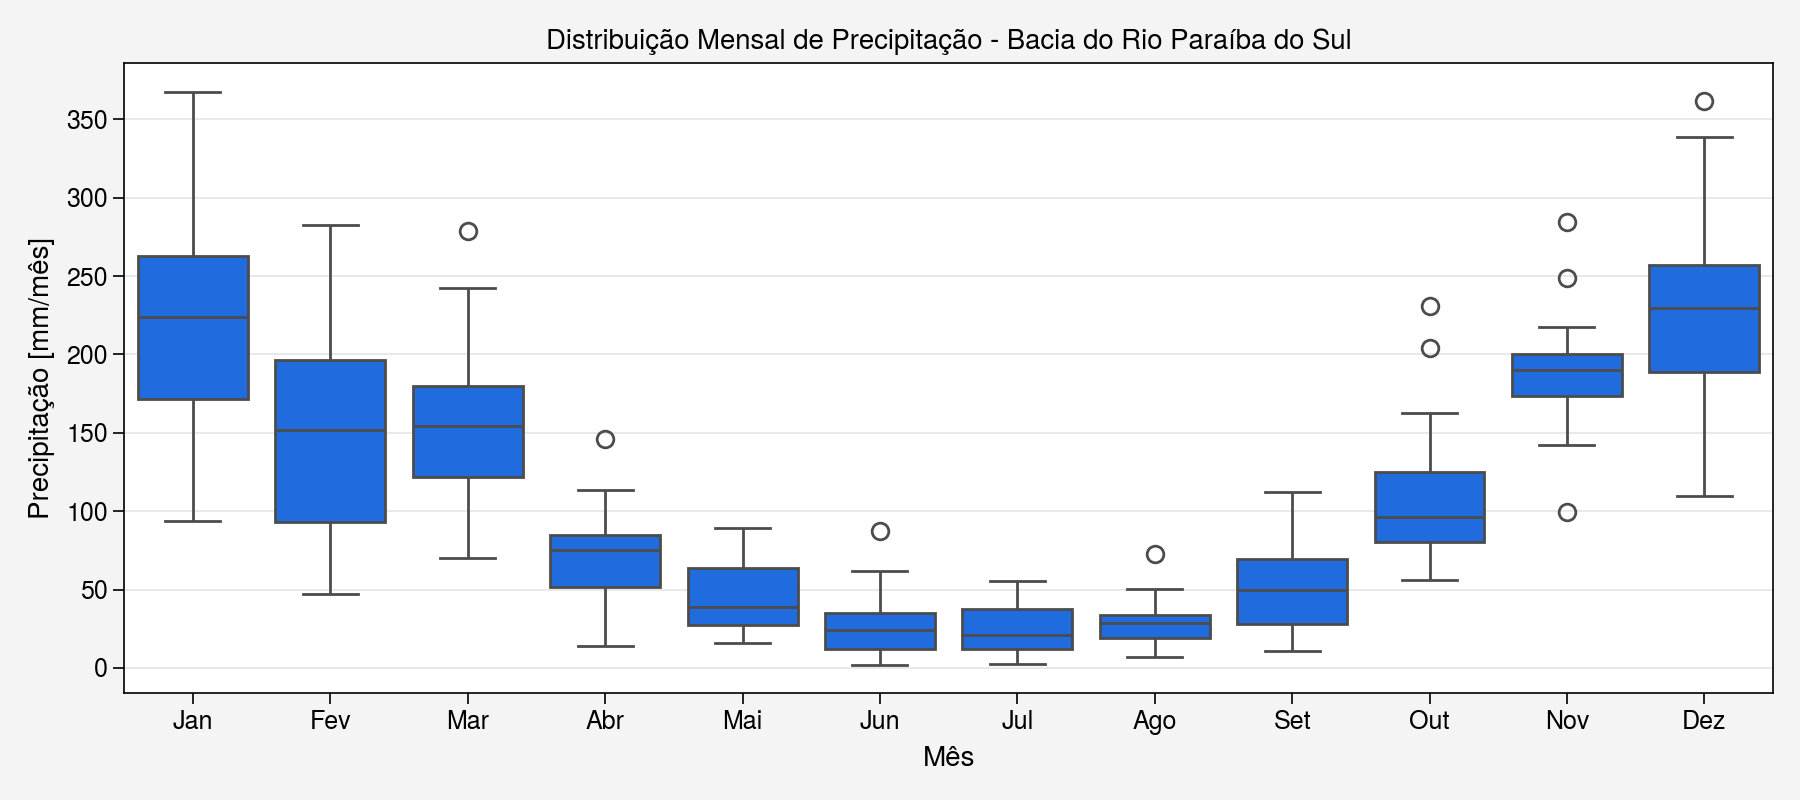

In [36]:
# cria moldura da figura
fig, ax = plt.subplots(figsize=(9, 4))

# criar boxplot de precipitação mensal
sns.boxplot(x=ts_mensal.index.month,
            y=ts_mensal['pacum'],
            ax=ax,
            color='bright blue')

# formatação dos eixos
ax.set_title(f"Distribuição Mensal de Precipitação - {NAME}")
ax.set_xlabel('Mês', fontsize=10)
ax.set_ylabel('Precipitação [mm/mês]', fontsize=10)
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)

# salva figura
plt.savefig(f"Fig_3b_precipitacao_distribuicao_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
plt.tight_layout()
plt.show()

## **Figura 3c:** `MENSAL CLIMATOLÓGICA`

In [37]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,2.487140
2000-07-01 12:00:00,31.804784
2000-08-01 12:00:00,47.112397
2000-09-01 12:00:00,97.373200
2000-10-01 12:00:00,72.781250
...,...
2024-10-01 12:00:00,124.668724
2024-11-01 12:00:00,167.947788
2024-12-01 12:00:00,233.925412


In [38]:
# climatológica
mensal_climatologia = ts_mensal.groupby(ts_mensal.index.month).mean()
mensal_climatologia

,pacum
time,
1,223.100838
2,151.086481
3,156.623693
4,72.038184
5,44.162760
6,25.494815
7,24.408225
8,29.114820
9,53.324537


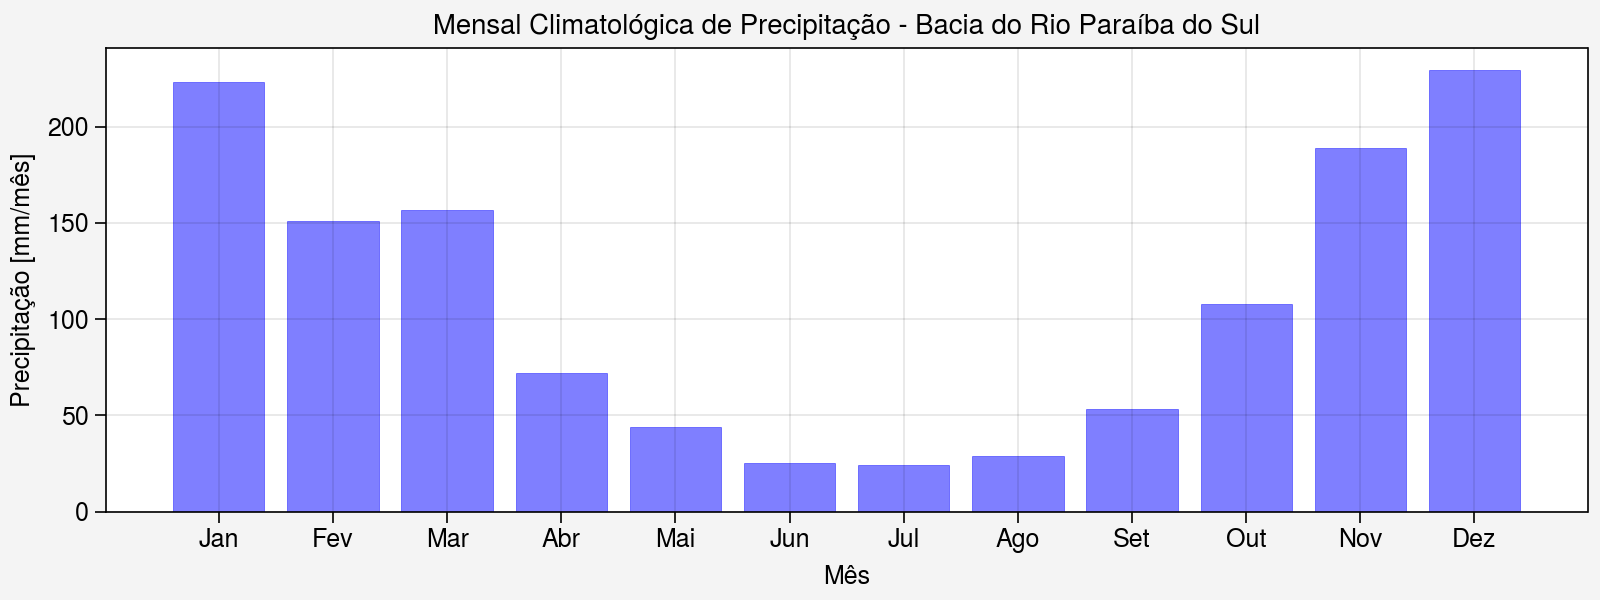

In [39]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(8, 3), tight=True)

# precipitação
ax.bar(uplt.arange(1, 12, 1),
       mensal_climatologia['pacum'],
       color='blue',
       alpha=0.5)

# formatações
ax.format(title=f"Mensal Climatológica de Precipitação - {NAME}",
          xlabel='Mês', ylabel='Precipitação [mm/mês]',
          xticklabels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
          xticks=uplt.arange(1, 12, 1),
          xtickminor=False, ytickminor=False)

# salva figura
fig.save(f"Fig_3c_precipitacao_mensal_climatologica_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 3d:** `POR ANO`

In [40]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,2.487140
2000-07-01 12:00:00,31.804784
2000-08-01 12:00:00,47.112397
2000-09-01 12:00:00,97.373200
2000-10-01 12:00:00,72.781250
...,...
2024-10-01 12:00:00,124.668724
2024-11-01 12:00:00,167.947788
2024-12-01 12:00:00,233.925412


In [41]:
# total
anual = ts_mensal.groupby(pd.Grouper(freq='1Y')).sum()
anual

,pacum
time,
2000-12-31,700.242541
2001-12-31,1205.516847
2002-12-31,1256.386188
2003-12-31,1243.573045
2004-12-31,1494.197659
2005-12-31,1291.576646
2006-12-31,1258.475309
2007-12-31,1137.565972
2008-12-31,1441.277521


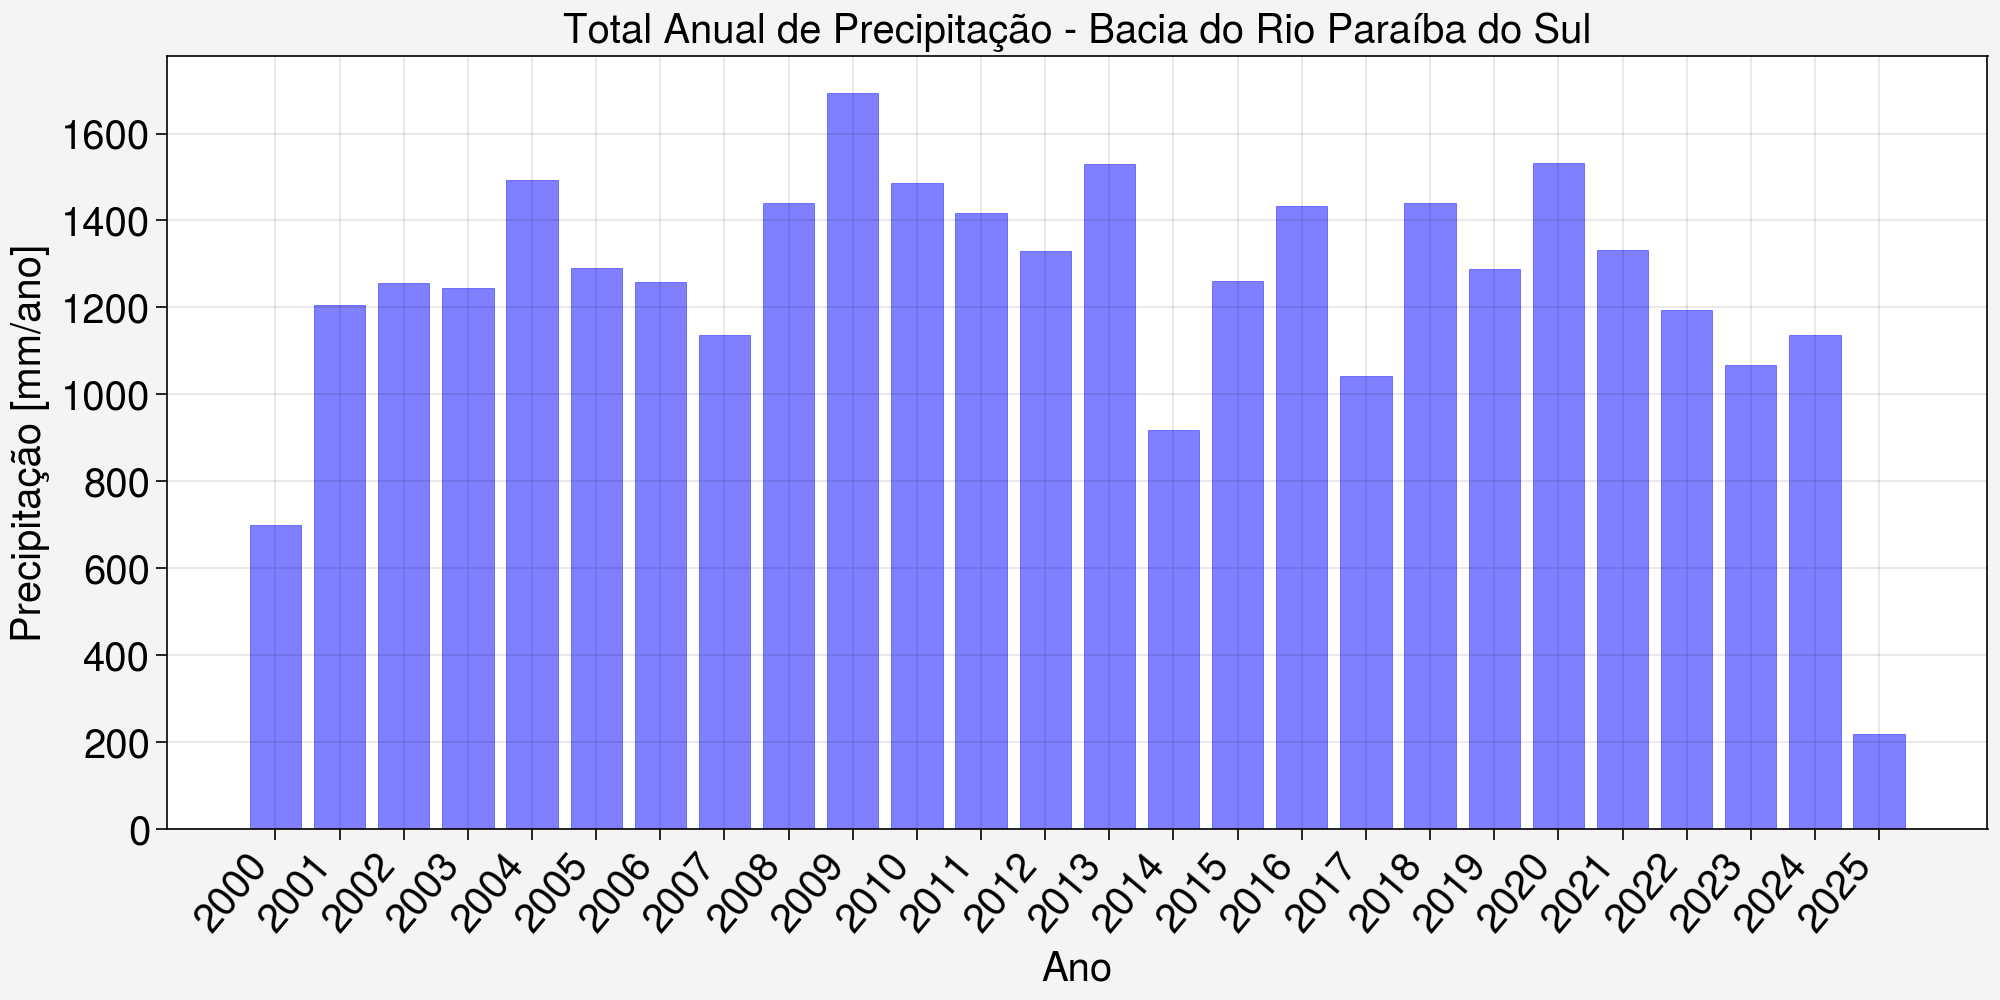

In [42]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(anual.index.year,
       anual['pacum'].values,
       color='blue',
       alpha=0.5)

# formatação do eixo
ax.format(title=f'Total Anual de Precipitação - {NAME}',
          xlabel='Ano',
          ylabel='Precipitação [mm/ano]',
          small='20px',
          large='20px',
          xtickminor=False,
          ytickminor=False,
          xticks=uplt.arange( anual.index.year[0], anual.index.year[-1], 1),
          xrotation=50)

# salva figura
fig.save(f"Fig_3d_precipitacao_total_anual_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

# **PARTE 4:** UMA LATITUDE E LONGITUDE

## **Processamento**

In [79]:
%%time
#==========================================================================#
#                           PARÂMETROS GERAIS                              #
#==========================================================================#
# localidade do ponto central
lat_central = -15.9
lon_central = -41.9

NAME = f'Lat={lat_central}/Lon={lon_central}'

#==========================================================================#
#                           PROCESSAMENTO
#==========================================================================#
# extrai a série temporal
ts_mensal = merge.sel(lat=lat_central, lon=(lon_central), method='nearest')

# converte para DataFrame
ts_mensal = ts_mensal.to_dataframe().reset_index().drop(columns=['lat', 'lon'])

# transforma a coluna "time" para o índice da tabela
ts_mensal['time'] = pd.to_datetime(ts_mensal['time'])
ts_mensal.set_index('time', inplace=True)

# ordena o dataframe
ts_mensal = ts_mensal.sort_index()
display(ts_mensal)
#==========================================================================#

,pacum
time,
2000-06-01 12:00:00,1.2500
2000-07-01 12:00:00,4.6250
2000-08-01 12:00:00,7.5000
2000-09-01 12:00:00,25.1250
2000-10-01 12:00:00,6.3750
...,...
2024-10-01 12:00:00,37.3750
2024-11-01 12:00:00,125.3125
2024-12-01 12:00:00,65.6875


CPU times: user 18.1 ms, sys: 927 ms, total: 945 ms
Wall time: 984 ms


## **Figura 4a:**  `TOTAL MENSAL`

In [80]:
# dado que será utilizado
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,1.250
2000-07-01 12:00:00,4.625
2000-08-01 12:00:00,7.500
2000-09-01 12:00:00,25.125


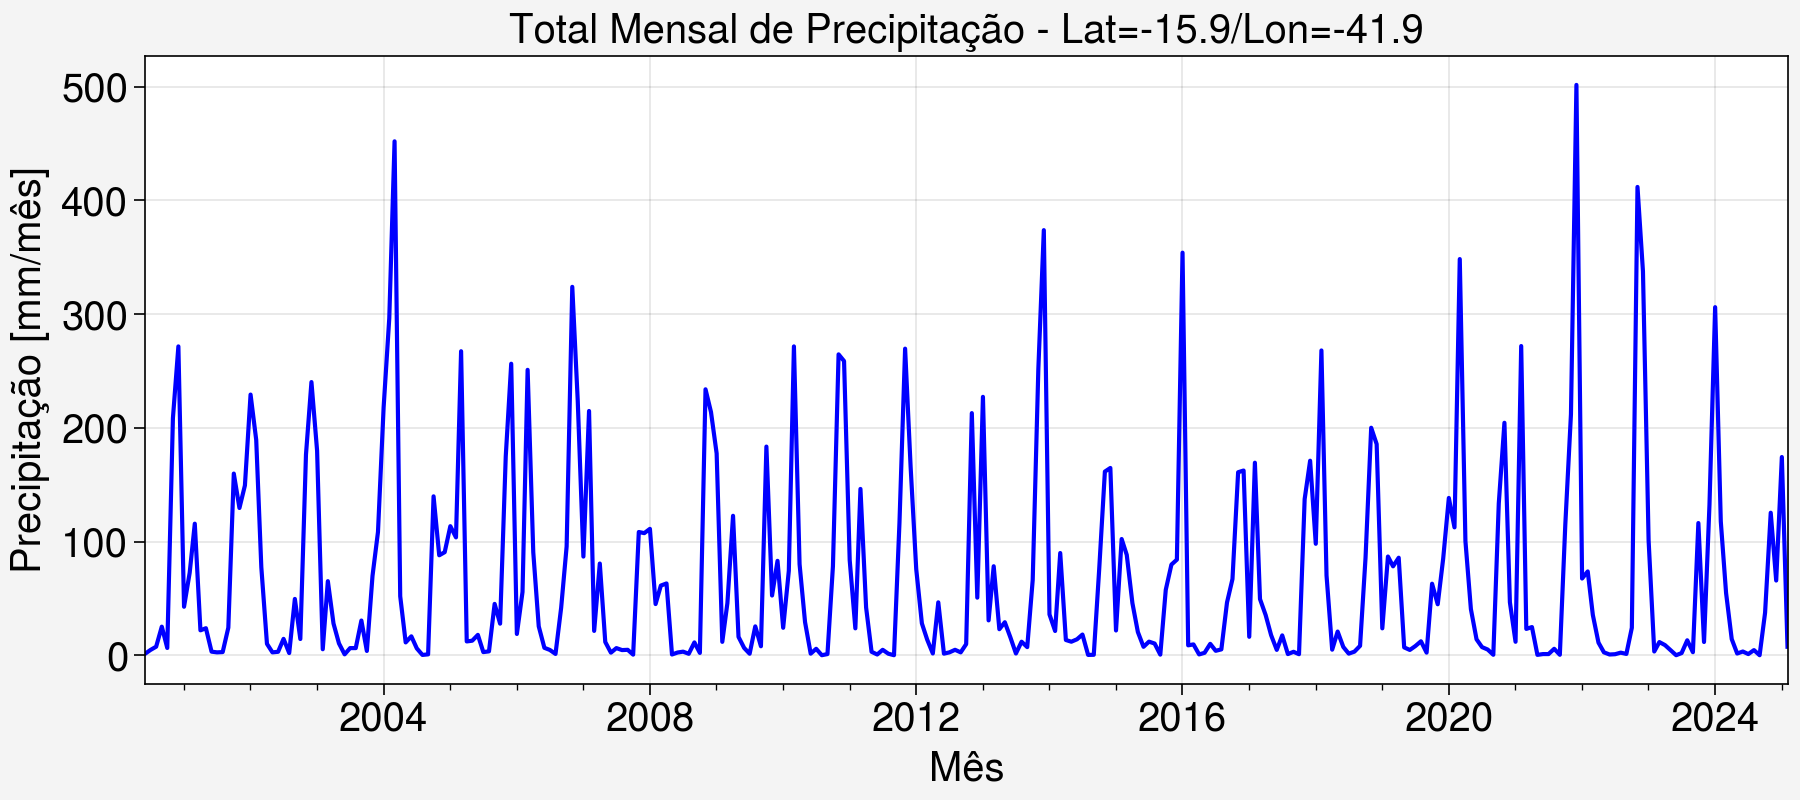

In [81]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(9,4), tight=True)

# plota gráfico de barras
ax.plot(ts_mensal['pacum'].index,
        ts_mensal['pacum'].values,
        color='blue')

# formato dos eixos
ax.format(title=f"Total Mensal de Precipitação - {NAME}",
          xlabel='Mês',
          ylabel='Precipitação [mm/mês]',
          small='20px',
          large='20px',
          xrotation=0,
          ytickminor=False)

# salva figura
fig.save(f"Fig_4a_precipitacao_total_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 4b:** `DISTRIBUIÇÃO MENSAL-BOXPLOT`

In [82]:
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,1.250
2000-07-01 12:00:00,4.625
2000-08-01 12:00:00,7.500
2000-09-01 12:00:00,25.125


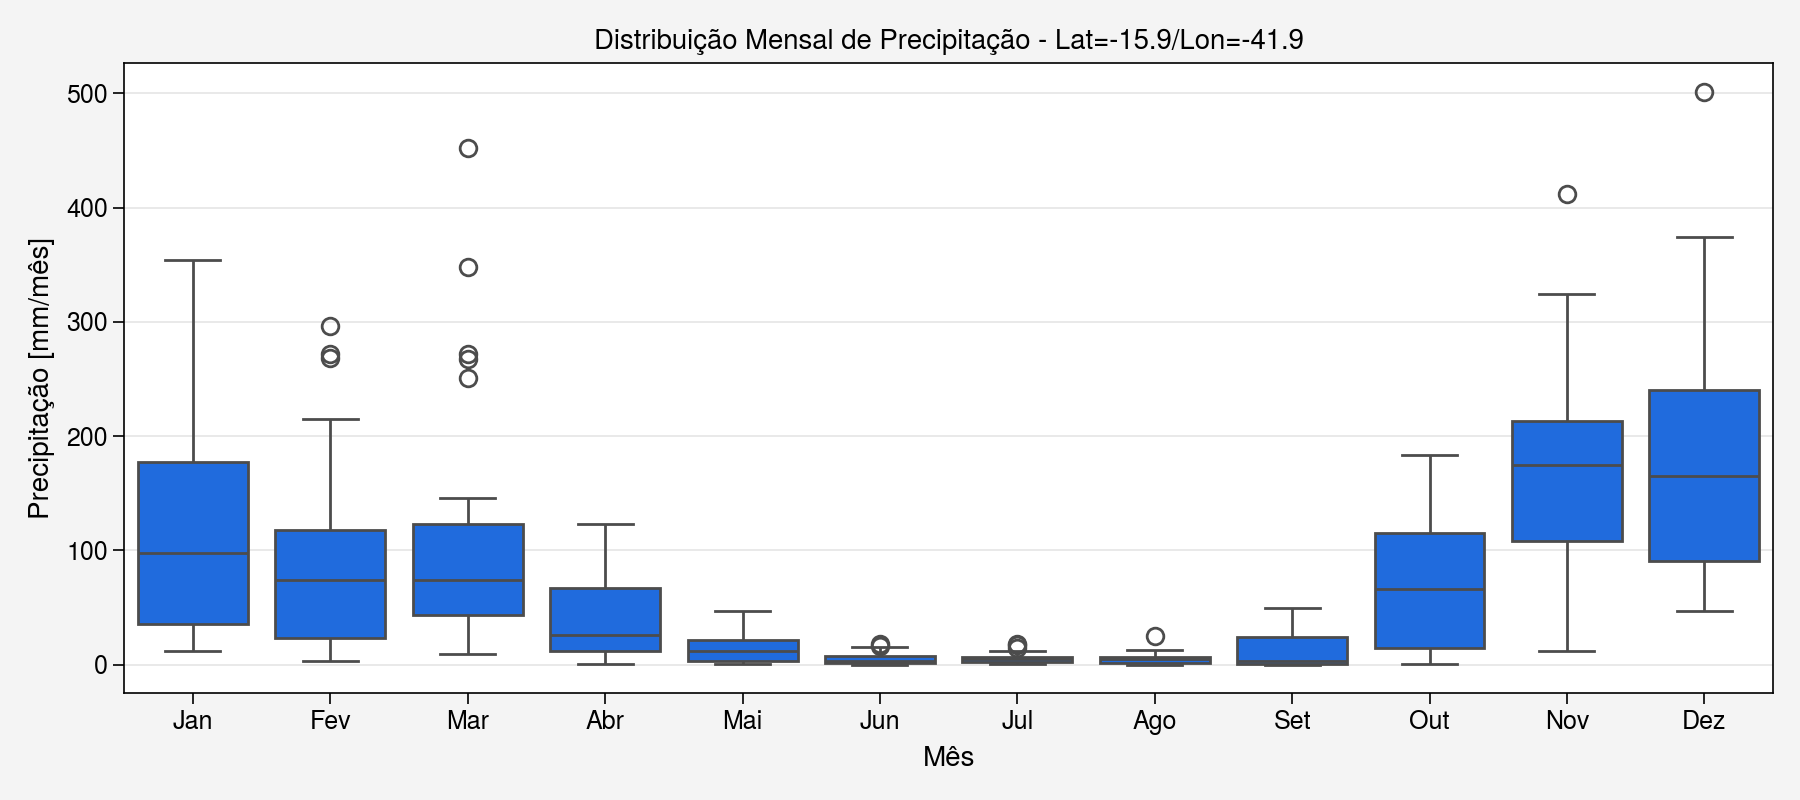

In [83]:
# cria moldura da figura
fig, ax = plt.subplots(figsize=(9, 4))

# criar boxplot de precipitação mensal
sns.boxplot(x=ts_mensal.index.month,
            y=ts_mensal['pacum'],
            ax=ax,
            color='bright blue')

# formatação dos eixos
ax.set_title(f"Distribuição Mensal de Precipitação - {NAME}")
ax.set_xlabel('Mês', fontsize=10)
ax.set_ylabel('Precipitação [mm/mês]', fontsize=10)
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)

# salva figura
plt.savefig(f"Fig_4b_precipitacao_distribuicao_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
plt.tight_layout()
plt.show()

## **Figura 4c:** `MENSAL CLIMATOLÓGICA`

In [84]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,1.2500
2000-07-01 12:00:00,4.6250
2000-08-01 12:00:00,7.5000
2000-09-01 12:00:00,25.1250
2000-10-01 12:00:00,6.3750
...,...
2024-10-01 12:00:00,37.3750
2024-11-01 12:00:00,125.3125
2024-12-01 12:00:00,65.6875


In [85]:
# climatológica
mensal_climatologia = ts_mensal.groupby(ts_mensal.index.month).mean()
mensal_climatologia

,pacum
time,
1,117.457500
2,95.750000
3,113.562500
4,40.505208
5,14.627604
6,5.832500
7,5.555000
8,5.387500
9,12.670000


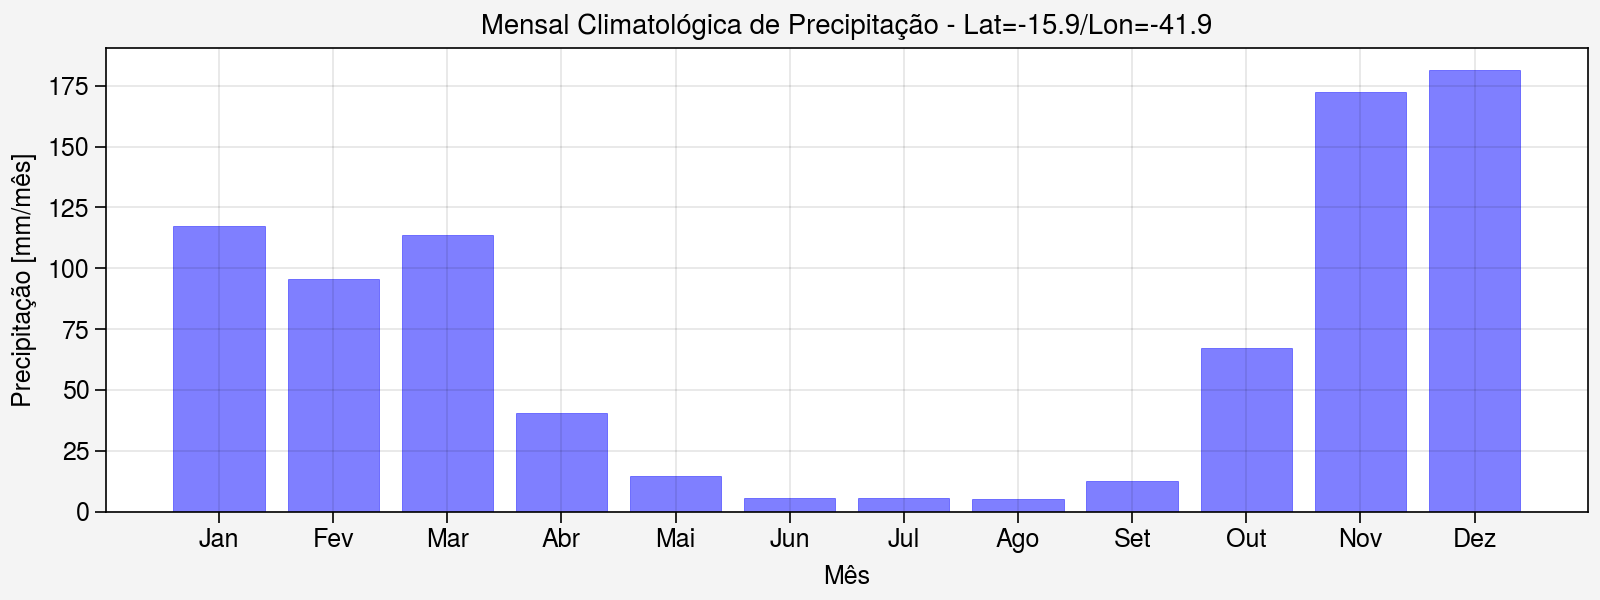

In [86]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(8, 3), tight=True)

# precipitação
ax.bar(uplt.arange(1, 12, 1),
       mensal_climatologia['pacum'],
       color='blue',
       alpha=0.5)

# formatações
ax.format(title=f"Mensal Climatológica de Precipitação - {NAME}",
          xlabel='Mês', ylabel='Precipitação [mm/mês]',
          xticklabels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
          xticks=uplt.arange(1, 12, 1),
          xtickminor=False, ytickminor=False)

# salva figura
fig.save(f"Fig_4c_precipitacao_mensal_climatologica_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 4d:** `POR ANO`

In [87]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,1.2500
2000-07-01 12:00:00,4.6250
2000-08-01 12:00:00,7.5000
2000-09-01 12:00:00,25.1250
2000-10-01 12:00:00,6.3750
...,...
2024-10-01 12:00:00,37.3750
2024-11-01 12:00:00,125.3125
2024-12-01 12:00:00,65.6875


In [88]:
# total
anual = ts_mensal.groupby(pd.Grouper(freq='1Y')).sum()
anual

,pacum
time,
2000-12-31,525.0000
2001-12-31,747.6875
2002-12-31,1008.2500
2003-12-31,514.1250
2004-12-31,1371.4375
2005-12-31,1037.5000
2006-12-31,1138.4375
2007-12-31,649.1875
2008-12-31,748.8750


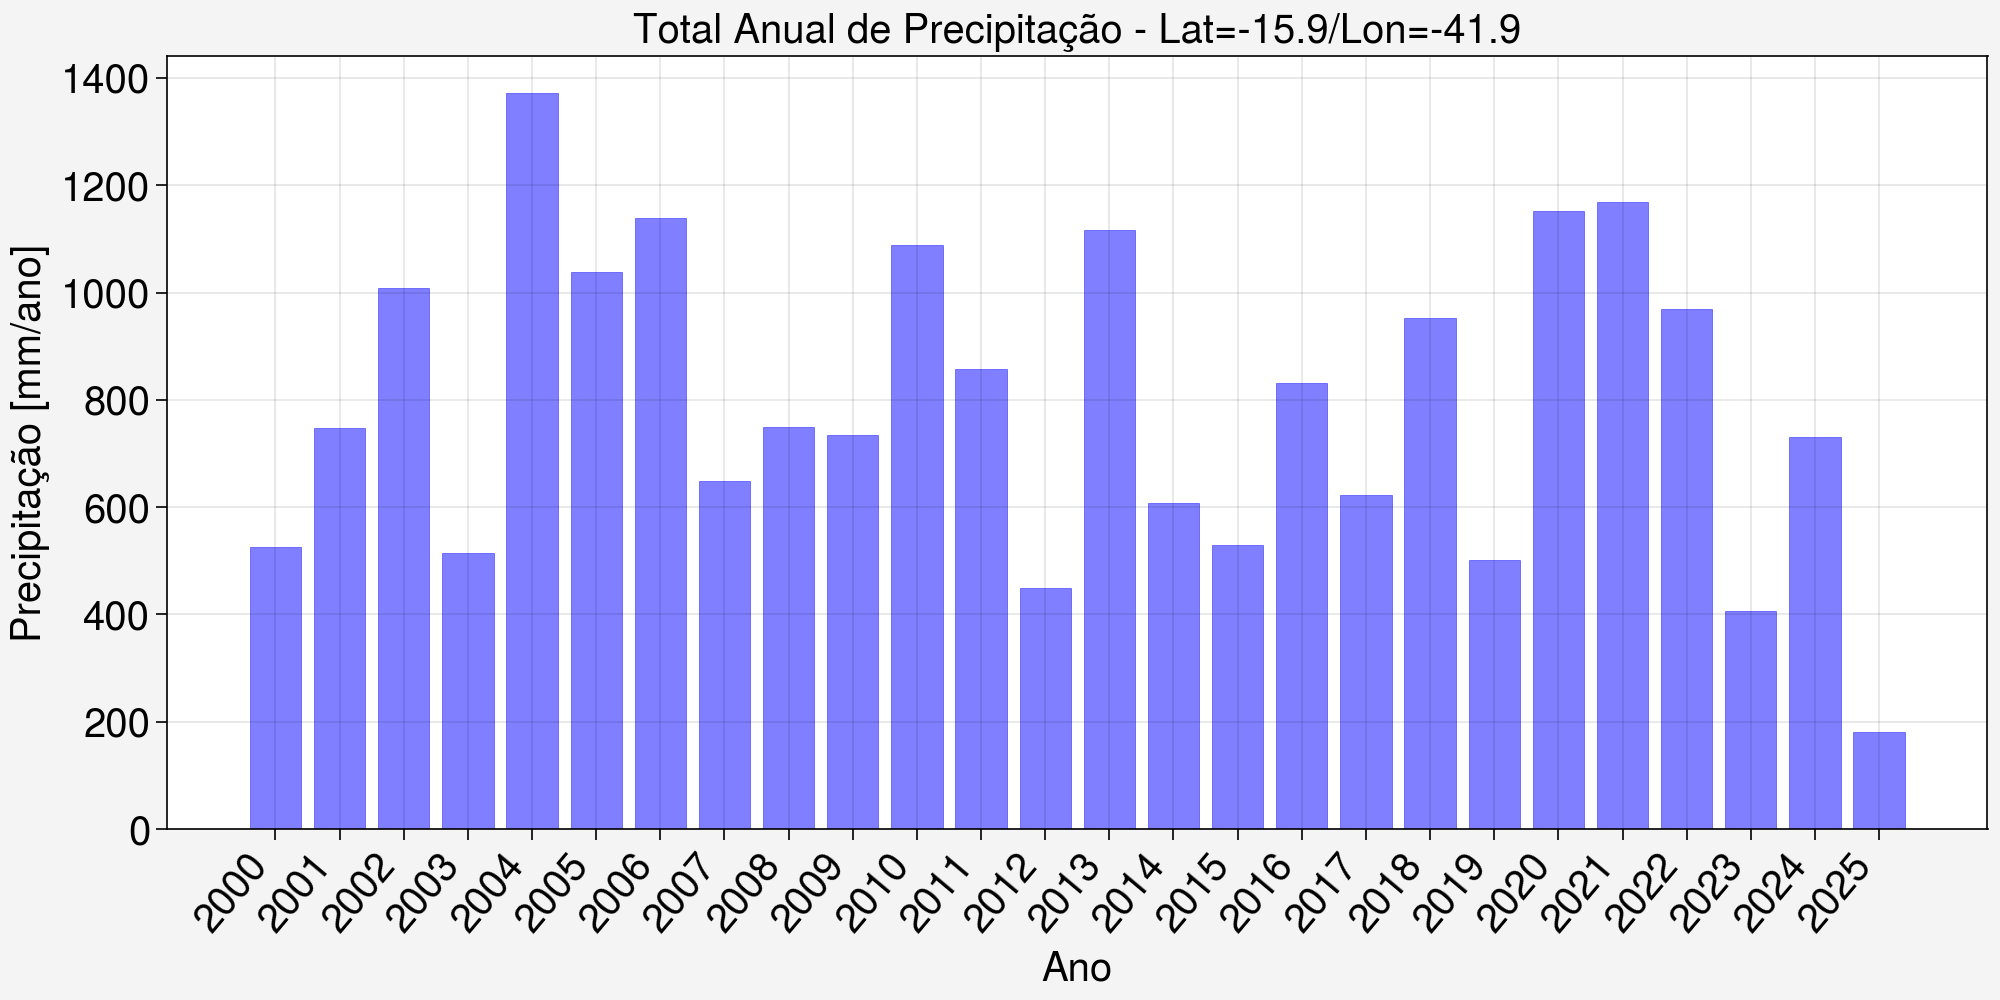

In [89]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(anual.index.year,
       anual['pacum'].values,
       color='blue',
       alpha=0.5)

# formatação do eixo
ax.format(title=f'Total Anual de Precipitação - {NAME}',
          xlabel='Ano',
          ylabel='Precipitação [mm/ano]',
          small='20px',
          large='20px',
          xtickminor=False,
          ytickminor=False,
          xticks=uplt.arange( anual.index.year[0], anual.index.year[-1], 1),
          xrotation=50)

# salva figura
fig.save(f"Fig_4d_precipitacao_total_anual_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

# **PARTE 5:** NUMA ÁREA

## **Processamento**

In [90]:
merge

<xarray.Dataset> Size: 905MB
Dimensions:  (lon: 551, lat: 691, time: 297)
Coordinates:
  * lon      (lon) float64 4kB -85.05 -84.95 -84.85 ... -30.25 -30.15 -30.05
  * lat      (lat) float64 6kB -56.15 -56.05 -55.95 -55.85 ... 12.65 12.75 12.85
  * time     (time) datetime64[ns] 2kB 2000-06-01T12:00:00 ... 2025-02-01T12:...
Data variables:
    pacum    (time, lat, lon) float64 905MB ...
Attributes:
    CDI:          Climate Data Interface version 1.8.2 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Sun Mar 16 21:40:11 2025: cdo mergetime MERGE_CPTEC_acum_ju...
    CDO:          Climate Data Operators version 1.8.2 (http://mpimet.mpg.de/...

In [91]:
%%time
#==========================================================================#
#                           PARÂMETROS GERAIS                              #
#==========================================================================#
# localidade do ponto central
lat_central = -15.9
lon_central = -41.9
ds_km = 20 # =20 km

# transforma de km para graus
ds_graus = ds_km/100.0

# limites do quadrado. Dimensoes de 40x40km2
lat_min = lat_central - ds_graus
lat_max = lat_central + ds_graus
lon_min = lon_central - ds_graus
lon_max = lon_central + ds_graus

# nome
NAME = f'Lat={lat_central}/Lon={lon_central}/buffer={ds_km}km'

#==========================================================================#
#                           PROCESSAMENTO
#==========================================================================#
# recorta para um quadrado
merge_regiao = merge.sel(lon=slice(lon_min, lon_max), lat=slice(lat_min, lat_max))

# calcula a média espacial dentro da região
ts_mensal = merge_regiao.mean(dim=['lat', 'lon'])

# converte para DataFrame
ts_mensal = ts_mensal.to_dataframe().reset_index()

# transforma a coluna "time" para o índice da tabela
ts_mensal['time'] = pd.to_datetime(ts_mensal['time'])
ts_mensal.set_index('time', inplace=True)

# ordena o dataframe
ts_mensal = ts_mensal.sort_index()
display(ts_mensal)
#==========================================================================#

,pacum
time,
2000-06-01 12:00:00,1.453125
2000-07-01 12:00:00,7.828125
2000-08-01 12:00:00,6.851562
2000-09-01 12:00:00,31.125000
2000-10-01 12:00:00,7.968750
...,...
2024-10-01 12:00:00,39.117188
2024-11-01 12:00:00,118.023438
2024-12-01 12:00:00,54.832031


CPU times: user 15.8 ms, sys: 317 ms, total: 332 ms
Wall time: 329 ms


## **Figura 5a:**  `TOTAL MENSAL`

In [92]:
# dado que será utilizado
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,1.453125
2000-07-01 12:00:00,7.828125
2000-08-01 12:00:00,6.851562
2000-09-01 12:00:00,31.125000


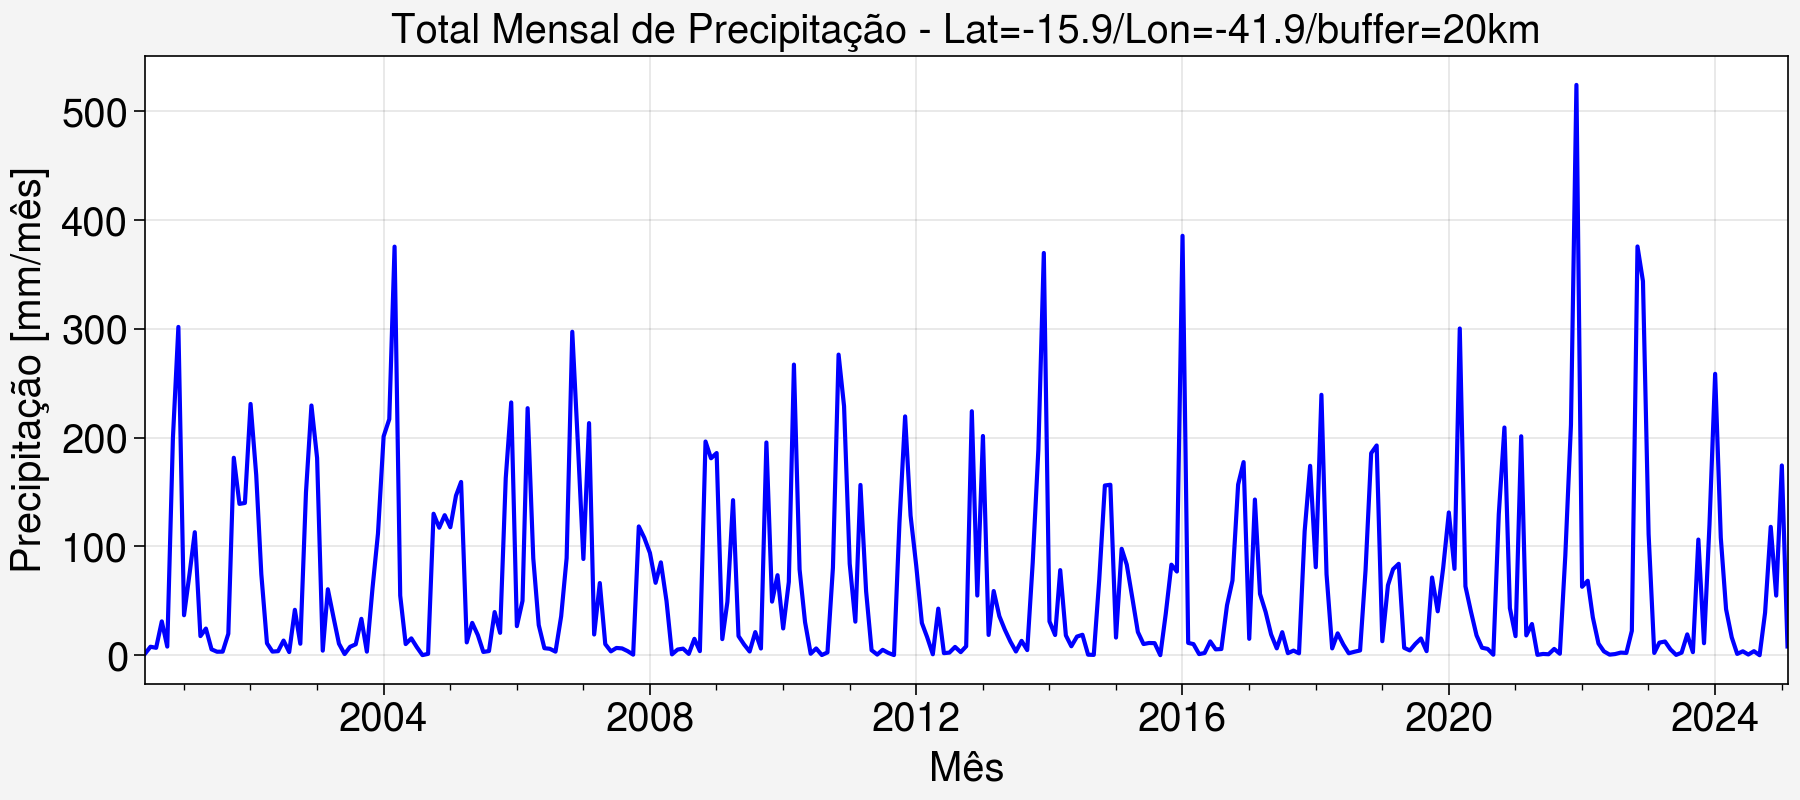

In [93]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(9,4), tight=True)

# plota gráfico de barras
ax.plot(ts_mensal['pacum'].index,
        ts_mensal['pacum'].values,
        color='blue')

# formato dos eixos
ax.format(title=f"Total Mensal de Precipitação - {NAME}",
          xlabel='Mês',
          ylabel='Precipitação [mm/mês]',
          small='20px',
          large='20px',
          xrotation=0,
          ytickminor=False)

# salva figura
fig.save(f"Fig_5a_precipitacao_total_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 5b:** `DISTRIBUIÇÃO MENSAL-BOXPLOT`

In [94]:
ts_mensal.head(4)

,pacum
time,
2000-06-01 12:00:00,1.453125
2000-07-01 12:00:00,7.828125
2000-08-01 12:00:00,6.851562
2000-09-01 12:00:00,31.125000


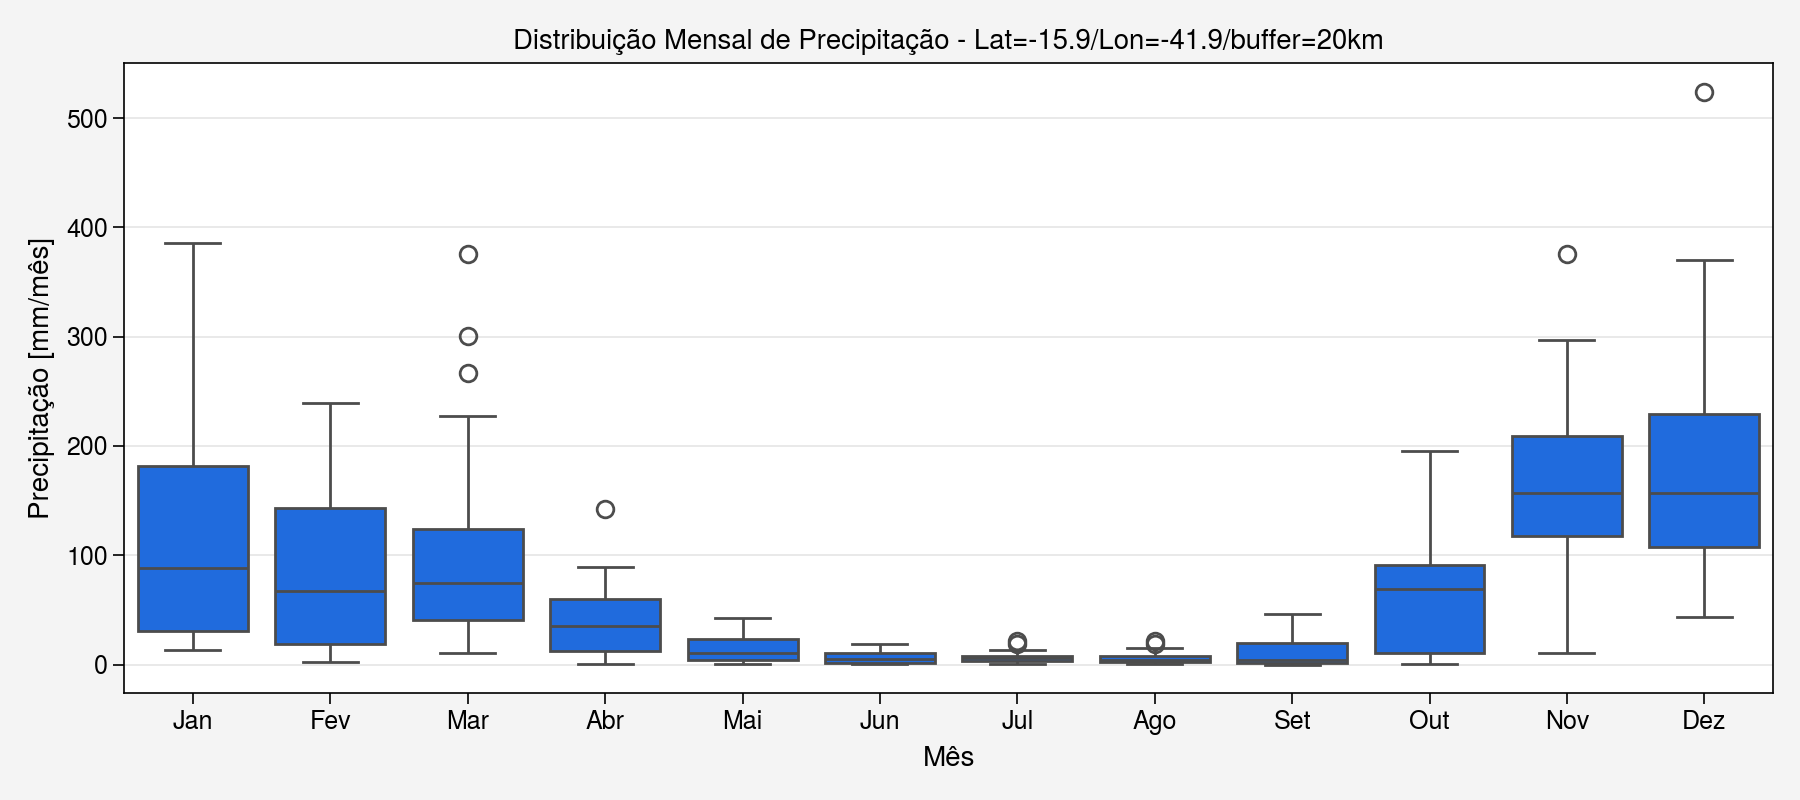

In [95]:
# cria moldura da figura
fig, ax = plt.subplots(figsize=(9, 4))

# criar boxplot de precipitação mensal
sns.boxplot(x=ts_mensal.index.month,
            y=ts_mensal['pacum'],
            ax=ax,
            color='bright blue')

# formatação dos eixos
ax.set_title(f"Distribuição Mensal de Precipitação - {NAME}")
ax.set_xlabel('Mês', fontsize=10)
ax.set_ylabel('Precipitação [mm/mês]', fontsize=10)
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)

# salva figura
plt.savefig(f"Fig_5b_precipitacao_distribuicao_mensal_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
plt.tight_layout()
plt.show()

## **Figura 5c:** `MENSAL CLIMATOLÓGICA`

In [96]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,1.453125
2000-07-01 12:00:00,7.828125
2000-08-01 12:00:00,6.851562
2000-09-01 12:00:00,31.125000
2000-10-01 12:00:00,7.968750
...,...
2024-10-01 12:00:00,39.117188
2024-11-01 12:00:00,118.023438
2024-12-01 12:00:00,54.832031


In [97]:
# climatológica
mensal_climatologia = ts_mensal.groupby(ts_mensal.index.month).mean()
mensal_climatologia

,pacum
time,
1,114.149531
2,85.718594
3,102.179362
4,41.095540
5,15.215658
6,6.886250
7,6.526250
8,6.300469
9,12.165000


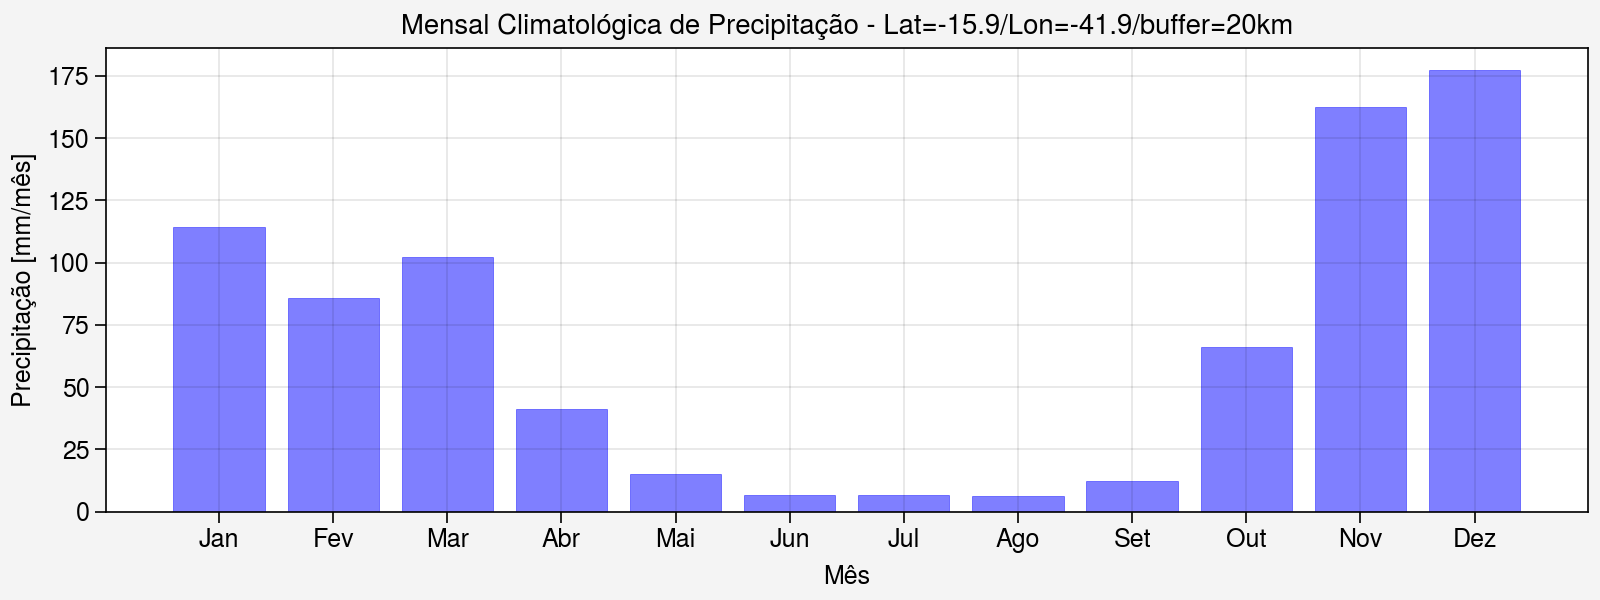

In [98]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(8, 3), tight=True)

# precipitação
ax.bar(uplt.arange(1, 12, 1),
       mensal_climatologia['pacum'],
       color='blue',
       alpha=0.5)

# formatações
ax.format(title=f"Mensal Climatológica de Precipitação - {NAME}",
          xlabel='Mês', ylabel='Precipitação [mm/mês]',
          xticklabels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'],
          xticks=uplt.arange(1, 12, 1),
          xtickminor=False, ytickminor=False)

# salva figura
fig.save(f"Fig_5c_precipitacao_mensal_climatologica_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()

## **Figura 5d:** `POR ANO`

In [99]:
# dados que iremos utilizar
ts_mensal

,pacum
time,
2000-06-01 12:00:00,1.453125
2000-07-01 12:00:00,7.828125
2000-08-01 12:00:00,6.851562
2000-09-01 12:00:00,31.125000
2000-10-01 12:00:00,7.968750
...,...
2024-10-01 12:00:00,39.117188
2024-11-01 12:00:00,118.023438
2024-12-01 12:00:00,54.832031


In [100]:
# total
anual = ts_mensal.groupby(pd.Grouper(freq='1Y')).sum()
anual

,pacum
time,
2000-12-31,556.546875
2001-12-31,760.285156
2002-12-31,937.359375
2003-12-31,520.929688
2004-12-31,1259.390625
2005-12-31,946.089844
2006-12-31,1055.726562
2007-12-31,644.902344
2008-12-31,705.574219


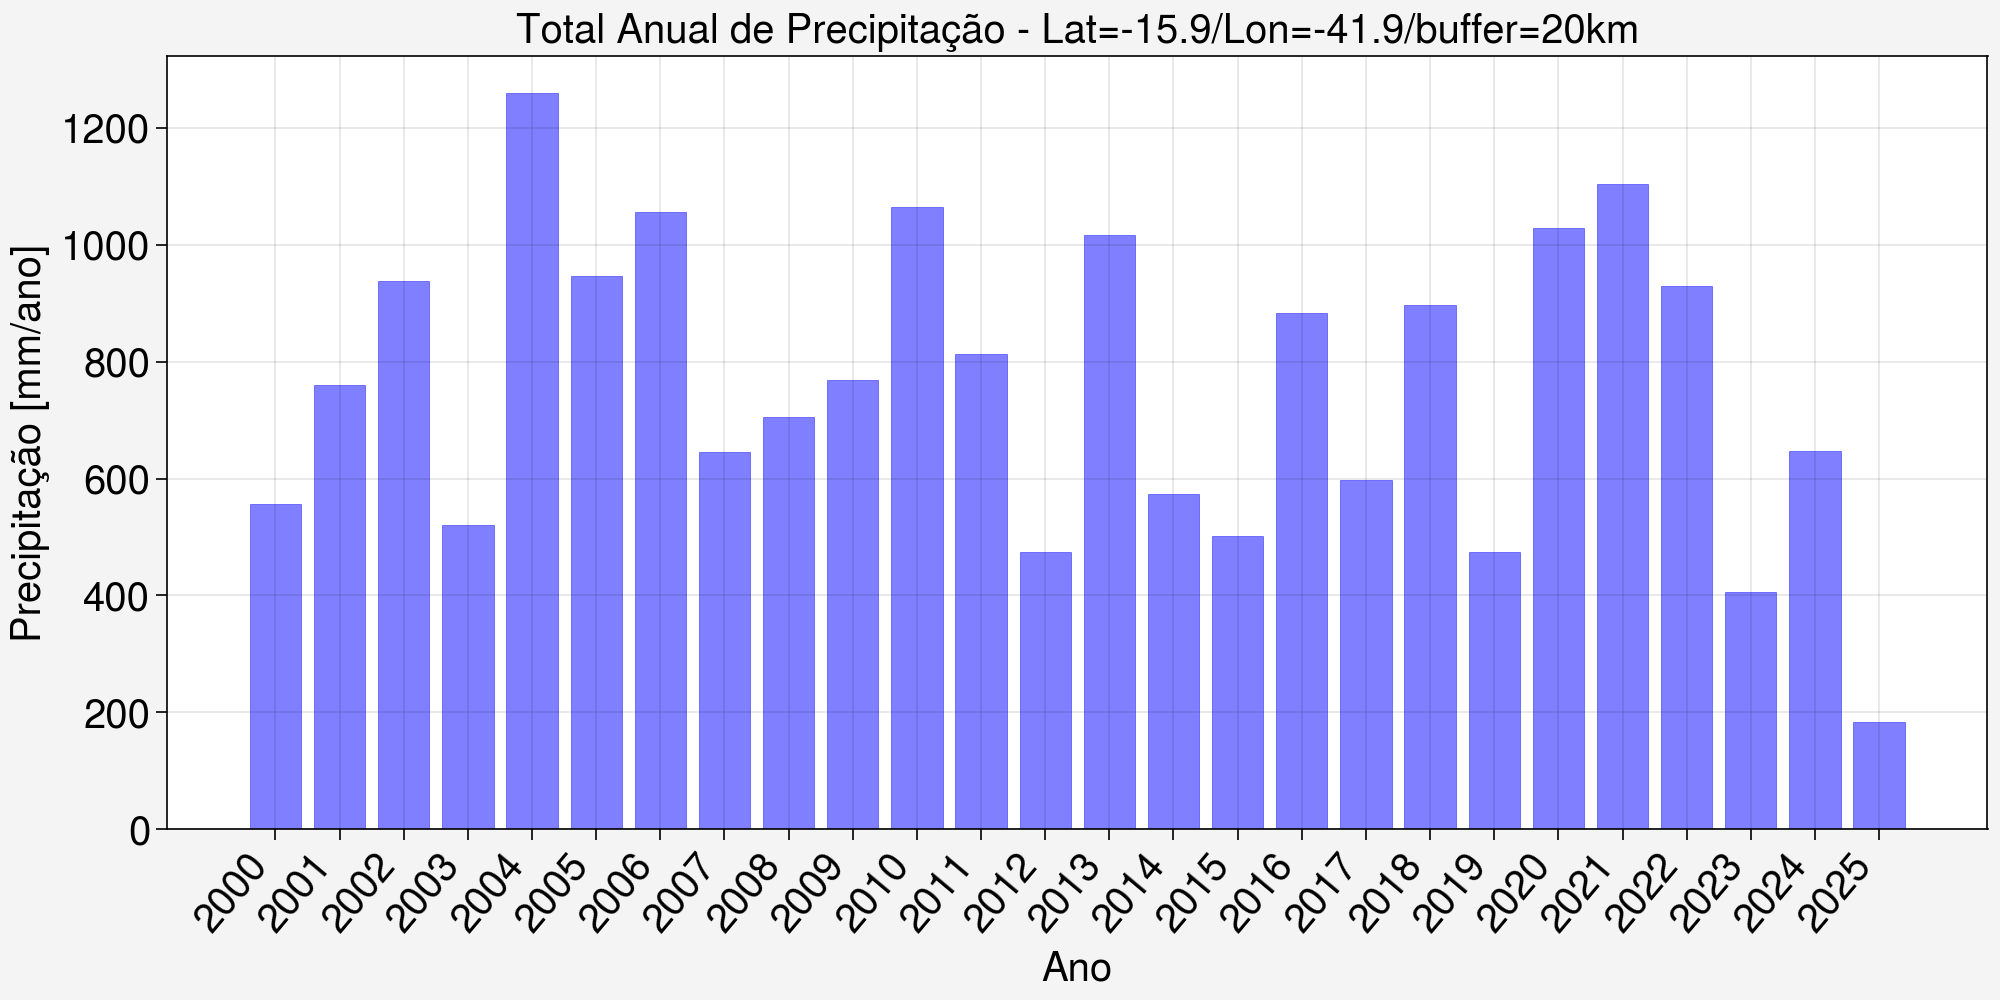

In [101]:
# cria moldura da figura
fig, ax = uplt.subplots(figsize=(10, 5), tight=True)

# precipitação
ax.bar(anual.index.year,
       anual['pacum'].values,
       color='blue',
       alpha=0.5)

# formatação do eixo
ax.format(title=f'Total Anual de Precipitação - {NAME}',
          xlabel='Ano',
          ylabel='Precipitação [mm/ano]',
          small='20px',
          large='20px',
          xtickminor=False,
          ytickminor=False,
          xticks=uplt.arange( anual.index.year[0], anual.index.year[-1], 1),
          xrotation=50)

# salva figura
fig.save(f"Fig_5d_precipitacao_total_anual_{NAME.replace('/', '_').replace(' ', '_')}.jpg", dpi=300)

# exibe figura na tela
uplt.show()